<a href="https://colab.research.google.com/github/jithsg/MODELING/blob/main/Another_copy_of_Hybrid_pmos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.2 MB/s eta 0:00:00


In [4]:
import optuna
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# === X_scaled, y_combined must be defined from your preprocessing ===
# X_scaled → shape (n_samples, 6)
# y_combined → shape (n_samples, 3) [log10(Id), gm_scaled, gd_scaled]

X_train_opt, X_val_opt, y_train_opt, y_val_opt = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

# === Optuna Objective Function ===
def objective(trial):
    # Loss term weights to tune
    w_Id   = trial.suggest_float("w_Id", 2.0, 6.0)
    w_gm   = trial.suggest_float("w_gm", 1.0, 4.0)
    w_gd   = trial.suggest_float("w_gd", 0.5, 2.0)
    w_gm_s = trial.suggest_float("w_gm_smooth", 0.001, 0.05)
    w_gd_s = trial.suggest_float("w_gd_smooth", 0.001, 0.05)
    w_gm_2 = trial.suggest_float("w_gm_second", 0.0001, 0.01)
    w_gd_2 = trial.suggest_float("w_gd_second", 0.0001, 0.01)

    # Define loss function with trial weights
    def hybrid_loss_opt(y_true, y_pred):
        log_Id_true = y_true[:, 0]
        gm_true     = y_true[:, 1]
        gd_true     = y_true[:, 2]

        log_Id_pred = y_pred[:, 0]
        gm_pred     = y_pred[:, 1]
        gd_pred     = y_pred[:, 2]

        loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
        loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
        loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

        gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
        gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

        gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
        gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

        return (
            w_Id * loss_Id +
            w_gm * loss_gm +
            w_gd * loss_gd +
            w_gm_s * gm_smooth +
            w_gd_s * gd_smooth +
            w_gm_2 * gm_second +
            w_gd_2 * gd_second
        )

    # Define model
    model = Sequential([
        Input(shape=(6,)),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(64, activation='tanh'),
        Dense(3)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss_opt)

    # Fit model
    model.fit(
        X_train_opt, y_train_opt,
        validation_data=(X_val_opt, y_val_opt),
        epochs=100,
        batch_size=64,
        verbose=0,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    # Evaluate validation I_ds MSE
    y_val_pred = model.predict(X_val_opt)
    log_Id_true = y_val_opt[:, 0]
    log_Id_pred = y_val_pred[:, 0]
    Id_true = 10 ** log_Id_true
    Id_pred = 10 ** log_Id_pred

    return mean_squared_error(Id_true, Id_pred)

# === Run Optuna Study ===
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

# === Print Best Parameters ===
print("\nBest loss weights found:")
for key, val in study.best_params.items():
    print(f"{key}: {val:.4f}")


[I 2025-05-09 16:45:25,270] A new study created in memory with name: no-name-bb9b455c-ba27-4b0b-8588-4eca6f89fa6a


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


[I 2025-05-09 16:46:03,388] Trial 0 finished with value: 1.284293655411943e-10 and parameters: {'w_Id': 2.525108474635792, 'w_gm': 2.61870608267413, 'w_gd': 0.9552660127757965, 'w_gm_smooth': 0.02637151617074354, 'w_gd_smooth': 0.010370954638079976, 'w_gm_second': 0.008410063504682626, 'w_gd_second': 0.007545490410725906}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:46:31,632] Trial 1 finished with value: 2.328867075043509e-10 and parameters: {'w_Id': 5.74099868178114, 'w_gm': 1.6641366078491098, 'w_gd': 1.3376589533527865, 'w_gm_smooth': 0.03128062067905941, 'w_gd_smooth': 0.026971809292195507, 'w_gm_second': 0.008131869342449813, 'w_gd_second': 0.009763331966929547}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:04,126] Trial 2 finished with value: 2.1503969397893068e-10 and parameters: {'w_Id': 5.210864068713551, 'w_gm': 2.4567804855131286, 'w_gd': 1.4570894550492506, 'w_gm_smooth': 0.015235584068062104, 'w_gd_smooth': 0.047709953337632754, 'w_gm_second': 0.0002882898628717637, 'w_gd_second': 0.0037377452557540505}. Best is trial 0 with value: 1.284293655411943e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:47:41,723] Trial 3 finished with value: 1.0970864292143141e-10 and parameters: {'w_Id': 2.5733139820865008, 'w_gm': 1.5636681338427767, 'w_gd': 1.2837947620985761, 'w_gm_smooth': 0.005339624499626156, 'w_gd_smooth': 0.03588261398845419, 'w_gm_second': 0.008090132286054482, 'w_gd_second': 0.0027249730445105293}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:07,795] Trial 4 finished with value: 4.449782141917571e-10 and parameters: {'w_Id': 5.714855843363008, 'w_gm': 1.431664774275986, 'w_gd': 0.8419695687128987, 'w_gm_smooth': 0.03766535518833621, 'w_gd_smooth': 0.0035263095019293887, 'w_gm_second': 0.0023090336595153857, 'w_gd_second': 0.001858558893205015}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:48:40,377] Trial 5 finished with value: 1.9872607084867326e-10 and parameters: {'w_Id': 4.921425905914983, 'w_gm': 3.210657016217744, 'w_gd': 1.182327338128778, 'w_gm_smooth': 0.048168578202739336, 'w_gd_smooth': 0.03648288624323011, 'w_gm_second': 0.0036606441085774615, 'w_gd_second': 0.009980825819554869}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:10,124] Trial 6 finished with value: 4.3163468879461184e-08 and parameters: {'w_Id': 2.6119603015713793, 'w_gm': 3.143202737796021, 'w_gd': 1.6282002708977306, 'w_gm_smooth': 0.0347554569935443, 'w_gd_smooth': 0.04850628519757475, 'w_gm_second': 0.0033917804592477154, 'w_gd_second': 0.008725303382350521}. Best is trial 3 with value: 1.0970864292143141e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:49:45,192] Trial 7 finished with value: 1.03582207529973e-10 and parameters: {'w_Id': 4.798155010651325, 'w_gm': 2.581478232440331, 'w_gd': 1.533429675828571, 'w_gm_smooth': 0.019438177938510603, 'w_gd_smooth': 0.02436087124893307, 'w_gm_second': 0.006481188064761129, 'w_gd_second': 0.006438926415808942}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:24,280] Trial 8 finished with value: 2.5170592503726784e-10 and parameters: {'w_Id': 3.3672755645470382, 'w_gm': 1.3935205002788558, 'w_gd': 0.7984867831772668, 'w_gm_smooth': 0.00655070023758318, 'w_gd_smooth': 0.005972494651898182, 'w_gm_second': 0.009701910218783177, 'w_gd_second': 0.006783040237440222}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:50:55,804] Trial 9 finished with value: 1.5291125097527042e-10 and parameters: {'w_Id': 2.713994495311458, 'w_gm': 1.369562812013406, 'w_gd': 1.7213113875636874, 'w_gm_smooth': 0.0016106568534056754, 'w_gd_smooth': 0.0029816978848805293, 'w_gm_second': 0.001983758631221469, 'w_gd_second': 0.008874857649013473}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:51:34,835] Trial 10 finished with value: 2.200655060246602e-10 and parameters: {'w_Id': 4.267675136360571, 'w_gm': 3.8803499597771416, 'w_gd': 1.9951740718700375, 'w_gm_smooth': 0.017203356740203297, 'w_gd_smooth': 0.017520068925201412, 'w_gm_second': 0.006172460192624349, 'w_gd_second': 0.00023713378126987653}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:08,235] Trial 11 finished with value: 1.4010636798723745e-10 and parameters: {'w_Id': 3.952808633760487, 'w_gm': 2.0497269387903403, 'w_gd': 0.5425675521242903, 'w_gm_smooth': 0.014800340166855237, 'w_gd_smooth': 0.030926808782296783, 'w_gm_second': 0.006156881291788535, 'w_gd_second': 0.004686671716369662}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:52:40,615] Trial 12 finished with value: 1.996460857200093e-10 and parameters: {'w_Id': 2.0490503953758172, 'w_gm': 2.053465014421755, 'w_gd': 1.103878728261562, 'w_gm_smooth': 0.009363626970260178, 'w_gd_smooth': 0.03521050956991325, 'w_gm_second': 0.00692600052805965, 'w_gd_second': 0.003157232775888227}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:13,836] Trial 13 finished with value: 3.205469888577667e-10 and parameters: {'w_Id': 4.338522253476978, 'w_gm': 1.0167385097682766, 'w_gd': 1.5416690570383245, 'w_gm_smooth': 0.02261238507546403, 'w_gd_smooth': 0.016653917557890488, 'w_gm_second': 0.004636166150313364, 'w_gd_second': 0.00596532597501202}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:53:47,181] Trial 14 finished with value: 2.2621477020709267e-10 and parameters: {'w_Id': 3.5495004946985196, 'w_gm': 2.795423647141415, 'w_gd': 1.8180039416638083, 'w_gm_smooth': 0.00789589257072473, 'w_gd_smooth': 0.041233699286558956, 'w_gm_second': 0.007841099243133923, 'w_gd_second': 0.002142098051867045}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:18,351] Trial 15 finished with value: 1.638469930332012e-10 and parameters: {'w_Id': 4.912558497325177, 'w_gm': 2.072246119297343, 'w_gd': 1.354085113711194, 'w_gm_smooth': 0.02150387679162183, 'w_gd_smooth': 0.02159639939201472, 'w_gm_second': 0.009983171433189891, 'w_gd_second': 0.005186192515932755}. Best is trial 7 with value: 1.03582207529973e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:54:52,089] Trial 16 finished with value: 1.0248681925654913e-10 and parameters: {'w_Id': 3.2088941303854384, 'w_gm': 3.6969661426950857, 'w_gd': 1.0623633314871652, 'w_gm_smooth': 0.002148469175921847, 'w_gd_smooth': 0.026620994954633492, 'w_gm_second': 0.005149324713964281, 'w_gd_second': 0.0001667748119033763}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:55:28,875] Trial 17 finished with value: 1.8407121240854644e-10 and parameters: {'w_Id': 3.297808377921649, 'w_gm': 3.973850946210488, 'w_gd': 0.5735251753508795, 'w_gm_smooth': 0.04353901146375848, 'w_gd_smooth': 0.0248270245874676, 'w_gm_second': 0.005249247843890989, 'w_gd_second': 0.0009394319391177474}. Best is trial 16 with value: 1.0248681925654913e-10.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:06,568] Trial 18 finished with value: 9.307551393587296e-11 and parameters: {'w_Id': 3.947713893807383, 'w_gm': 3.580130182558091, 'w_gd': 1.0310470392455926, 'w_gm_smooth': 0.028616939096605933, 'w_gd_smooth': 0.01406579762566183, 'w_gm_second': 0.004505151412378951, 'w_gd_second': 0.004511328276431005}. Best is trial 18 with value: 9.307551393587296e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:56:45,590] Trial 19 finished with value: 7.255931304594216e-11 and parameters: {'w_Id': 3.7996858459916356, 'w_gm': 3.5916236164965616, 'w_gd': 1.0632788936064497, 'w_gm_smooth': 0.02773364813840763, 'w_gd_smooth': 0.012407471368941067, 'w_gm_second': 0.004404892096928941, 'w_gd_second': 0.004340213566792695}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:21,946] Trial 20 finished with value: 1.184521714307075e-10 and parameters: {'w_Id': 3.884271182735457, 'w_gm': 3.4420896571706683, 'w_gd': 0.7589776364146769, 'w_gm_smooth': 0.027865228701586697, 'w_gd_smooth': 0.011152411360281831, 'w_gm_second': 0.003851359362946332, 'w_gd_second': 0.004372744369261027}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:57:59,612] Trial 21 finished with value: 1.5588605411720707e-10 and parameters: {'w_Id': 3.11963457694195, 'w_gm': 3.6185477803708155, 'w_gd': 1.0683599502921888, 'w_gm_smooth': 0.030847774100267428, 'w_gd_smooth': 0.015005232477606857, 'w_gm_second': 0.005024020201367263, 'w_gd_second': 0.005309073948684901}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:58:32,791] Trial 22 finished with value: 2.285717577112841e-10 and parameters: {'w_Id': 3.670477457897224, 'w_gm': 3.633328393574852, 'w_gd': 0.9785785349164164, 'w_gm_smooth': 0.03870227989422652, 'w_gd_smooth': 0.01016720667500716, 'w_gm_second': 0.002685640728744839, 'w_gd_second': 0.003637077064017359}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:00,223] Trial 23 finished with value: 3.369380223430565e-10 and parameters: {'w_Id': 4.336927103180093, 'w_gm': 3.4117816453582717, 'w_gd': 0.9564329204388701, 'w_gm_smooth': 0.024703443817555987, 'w_gd_smooth': 0.020122122992244352, 'w_gm_second': 0.004535644865410349, 'w_gd_second': 0.0014688689448707367}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 16:59:31,002] Trial 24 finished with value: 4.922811253969567e-10 and parameters: {'w_Id': 3.1073239013725518, 'w_gm': 3.0217776875197555, 'w_gd': 1.1721467857798233, 'w_gm_smooth': 0.03252403899007173, 'w_gd_smooth': 0.029032007779478407, 'w_gm_second': 0.005500112401901968, 'w_gd_second': 0.0004529525783629213}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:04,743] Trial 25 finished with value: 1.8551501090114462e-10 and parameters: {'w_Id': 2.938903657262007, 'w_gm': 3.7026912617958363, 'w_gd': 0.6863577693738838, 'w_gm_smooth': 0.012013372112282752, 'w_gd_smooth': 0.014987155911189048, 'w_gm_second': 0.0011906977606225048, 'w_gd_second': 0.0025952709343939275}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:00:38,860] Trial 26 finished with value: 2.426662917457488e-10 and parameters: {'w_Id': 3.6971379764751613, 'w_gm': 3.364925948801799, 'w_gd': 1.0656523217886225, 'w_gm_smooth': 0.02877631011014691, 'w_gd_smooth': 0.0077321474916973235, 'w_gm_second': 0.004334878852914713, 'w_gd_second': 0.004189106872757616}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:16,583] Trial 27 finished with value: 3.659958664586927e-10 and parameters: {'w_Id': 4.213119023020789, 'w_gm': 2.9213828409814337, 'w_gd': 1.2124886600346112, 'w_gm_smooth': 0.04133177009670118, 'w_gd_smooth': 0.012951940762991079, 'w_gm_second': 0.003112699458080374, 'w_gd_second': 0.0073716778835000146}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:01:55,733] Trial 28 finished with value: 9.603513669873365e-11 and parameters: {'w_Id': 4.522009126203086, 'w_gm': 3.7234913488032917, 'w_gd': 0.9648942212348361, 'w_gm_smooth': 0.02359402553546139, 'w_gd_smooth': 0.020933232718399933, 'w_gm_second': 0.007114180710681702, 'w_gd_second': 0.005681471272363093}. Best is trial 19 with value: 7.255931304594216e-11.


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


[I 2025-05-09 17:02:24,303] Trial 29 finished with value: 3.6335967144004525e-10 and parameters: {'w_Id': 4.60033953916491, 'w_gm': 3.8560756718881173, 'w_gd': 0.8584955971285357, 'w_gm_smooth': 0.025267183231564655, 'w_gd_smooth': 0.020459404180900028, 'w_gm_second': 0.007309697243629962, 'w_gd_second': 0.005712400499140809}. Best is trial 19 with value: 7.255931304594216e-11.



Best loss weights found:
w_Id: 3.7997
w_gm: 3.5916
w_gd: 1.0633
w_gm_smooth: 0.0277
w_gd_smooth: 0.0124
w_gm_second: 0.0044
w_gd_second: 0.0043


In [7]:

def hybrid_loss(y_true, y_pred):
    log_Id_true = y_true[:, 0]
    gm_true     = y_true[:, 1]
    gd_true     = y_true[:, 2]

    log_Id_pred = y_pred[:, 0]
    gm_pred     = y_pred[:, 1]
    gd_pred     = y_pred[:, 2]

    loss_Id = tf.reduce_mean(tf.square(log_Id_true - log_Id_pred))
    log_Id_smooth = tf.reduce_mean(tf.square(log_Id_pred[1:] - log_Id_pred[:-1]))
    log_Id_second = tf.reduce_mean(tf.square(log_Id_pred[2:] - 2 * log_Id_pred[1:-1] + log_Id_pred[:-2]))

    loss_gm = tf.reduce_mean(tf.square(gm_true - gm_pred))
    loss_gd = tf.reduce_mean(tf.square(gd_true - gd_pred))

    gm_smooth = tf.reduce_mean(tf.square(gm_pred[1:] - gm_pred[:-1]))
    gd_smooth = tf.reduce_mean(tf.square(gd_pred[1:] - gd_pred[:-1]))

    gm_second = tf.reduce_mean(tf.square(gm_pred[2:] - 2 * gm_pred[1:-1] + gm_pred[:-2]))
    gd_second = tf.reduce_mean(tf.square(gd_pred[2:] - 2 * gd_pred[1:-1] + gd_pred[:-2]))

    return (
        3.7997 * loss_Id +
        3.5916 * loss_gm +
        1.0633 * loss_gd +
        0.0277 * gm_smooth +
        0.0124 * gd_smooth +
        0.0044 * gm_second +
        0.0043 * gd_second

    )

In [10]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.callbacks import ModelCheckpoint


device_files = [
    "pfet_120_40.csv",
    "pfet_200_40.csv",
    "pfet_200_80.csv",
    "pfet_400_40.csv",
    "pfet_800_40.csv"
]

flattened_vectors = []
per_device_raw_data = []

for path in device_files:
    df = pd.read_csv(path).sort_values(by=["Vgs(V)", "Vds(V)"])
    Id = df["Id(A)"].values
    gm = df["gm"].values
    gds = df["gds"].values
    flat = np.stack([Id, gm, gds], axis=1).flatten()
    flattened_vectors.append(flat)
    per_device_raw_data.append(df)

device_matrix = np.array(flattened_vectors)
pca = PCA(n_components=3)
device_signatures = pca.fit_transform(device_matrix)

X, y_id, y_gm, y_gd = [], [], [], []
for i, df in enumerate(per_device_raw_data):
    P = device_signatures[i]
    for _, row in df.iterrows():
        vgs = row["Vgs(V)"]
        vds = row["Vds(V)"]
        temp = row["Temp"]
        id_val = max(row["Id(A)"], 1e-12)
        gm_val = row["gm"]
        gd_val = row["gds"]
        X.append([*P, vgs, vds, temp])
        y_id.append(np.log10(id_val))
        y_gm.append(gm_val)
        y_gd.append(gd_val)

X = np.array(X)
y_id = np.array(y_id)
y_gm = np.array(y_gm)
y_gd = np.array(y_gd)

scaler_gm = StandardScaler()
scaler_gd = StandardScaler()
y_gm_scaled = scaler_gm.fit_transform(y_gm.reshape(-1, 1)).flatten()
y_gd_scaled = scaler_gd.fit_transform(y_gd.reshape(-1, 1)).flatten()

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_combined = np.stack([y_id, y_gm_scaled, y_gd_scaled], axis=1)

# Step 2: Train/Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_combined, test_size=0.2, random_state=42)

In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

final_model = Sequential([
    Input(shape=(6,)),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(64, activation='tanh'),
    Dense(3)
])

final_model.compile(optimizer=Adam(learning_rate=0.001), loss=hybrid_loss)

# Save best model
checkpoint = ModelCheckpoint(
    "best_final_model.h5",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train with validation split
history = final_model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=400,
    batch_size=160,
    verbose=1,
    callbacks=[checkpoint]
)



Epoch 1/400
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 65.9825
Epoch 1: val_loss improved from inf to 16.92670, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 12s 136ms/step - loss: 65.3344 - val_loss: 16.9267
Epoch 2/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16.0346 
Epoch 2: val_loss improved from 16.92670 to 13.10420, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 15.3783 - val_loss: 13.1042
Epoch 3/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.5358 
Epoch 3: val_loss improved from 13.10420 to 12.02897, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 12.4726 - val_loss: 12.0290
Epoch 4/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.6028 
Epoch 4: val_loss improved from 12.02897 to 11.34381, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.5537 - val_loss: 11.3438
Epoch 5/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.2165 
Epoch 5: val_loss improved from 11.34381 to 10.86725, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 11.1424 - val_loss: 10.8672
Epoch 6/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11.0153
Epoch 6: val_loss improved from 10.86725 to 10.20450, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.8148 - val_loss: 10.2045
Epoch 7/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10.0075 
Epoch 7: val_loss improved from 10.20450 to 9.78738, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 10.0093 - val_loss: 9.7874
Epoch 8/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.8748 
Epoch 8: val_loss improved from 9.78738 to 8.91736, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7632 - val_loss: 8.9174
Epoch 9/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.2689 
Epoch 9: val_loss improved from 8.91736 to 7.95907, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0876 - val_loss: 7.9591
Epoch 10/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.4985  
Epoch 10: val_loss improved from 7.95907 to 6.73416, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2029 - val_loss: 6.7342
Epoch 11/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.1594 
Epoch 11: val_loss improved from 6.73416 to 5.18128, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1524 - val_loss: 5.1813
Epoch 12/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.7265 
Epoch 12: val_loss improved from 5.18128 to 4.26127, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5202 - val_loss: 4.2613
Epoch 13/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.4313 
Epoch 13: val_loss improved from 4.26127 to 3.85570, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4527 - val_loss: 3.8557
Epoch 14/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.9819 
Epoch 14: val_loss improved from 3.85570 to 3.61101, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9771 - val_loss: 3.6110
Epoch 15/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.5028 
Epoch 15: val_loss improved from 3.61101 to 3.37400, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6103 - val_loss: 3.3740
Epoch 16/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.4014 
Epoch 16: val_loss improved from 3.37400 to 3.21587, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4450 - val_loss: 3.2159
Epoch 17/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8838 
Epoch 17: val_loss improved from 3.21587 to 3.21011, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7726 - val_loss: 3.2101
Epoch 18/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.6088 
Epoch 18: val_loss improved from 3.21011 to 2.88750, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5355 - val_loss: 2.8875
Epoch 19/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.3217 
Epoch 19: val_loss improved from 2.88750 to 2.80299, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2934 - val_loss: 2.8030
Epoch 20/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.1107 
Epoch 20: val_loss improved from 2.80299 to 2.68253, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0688 - val_loss: 2.6825
Epoch 21/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.4466 
Epoch 21: val_loss improved from 2.68253 to 2.52203, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6285 - val_loss: 2.5220
Epoch 22/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0281 
Epoch 22: val_loss did not improve from 2.52203
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.9757 - val_loss: 2.5411
Epoch 23/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0005 
Epoch 23: val_loss improved from 2.52203 to 2.40887, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9340 - val_loss: 2.4089
Epoch 24/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.7684 
Epoch 24: val_loss improved from 2.40887 to 2.33244, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7159 - val_loss: 2.3324
Epoch 25/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2621 
Epoch 25: val_loss improved from 2.33244 to 2.24205, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3037 - val_loss: 2.2421
Epoch 26/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3688 
Epoch 26: val_loss improved from 2.24205 to 2.13152, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3793 - val_loss: 2.1315
Epoch 27/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1309 
Epoch 27: val_loss did not improve from 2.13152
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1742 - val_loss: 2.2806
Epoch 28/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0792 
Epoch 28: val_loss improved from 2.13152 to 1.97766, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1165 - val_loss: 1.9777
Epoch 29/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9965 
Epoch 29: val_loss did not improve from 1.97766
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0431 - val_loss: 2.3379
Epoch 30/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.1946 
Epoch 30: val_loss improved from 1.97766 to 1.91362, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1524 - val_loss: 1.9136
Epoch 31/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0686 
Epoch 31: val_loss did not improve from 1.91362
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0339 - val_loss: 1.9418
Epoch 32/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.0268 
Epoch 32: val_loss did not improve from 1.91362
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0240 - val_loss: 2.0985
Epoch 33/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9414 
Epoch 33: val_loss improved from 1.91362 to 1.88432, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9108 - val_loss: 1.8843
Epoch 34/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.9560 
Epoch 34: val_loss improved from 1.88432 to 1.61913, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8831 - val_loss: 1.6191
Epoch 35/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5005 
Epoch 35: val_loss improved from 1.61913 to 1.53445, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5399 - val_loss: 1.5345
Epoch 36/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.7565 
Epoch 36: val_loss improved from 1.53445 to 1.45136, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7020 - val_loss: 1.4514
Epoch 37/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5329 
Epoch 37: val_loss improved from 1.45136 to 1.36006, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5271 - val_loss: 1.3601
Epoch 38/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6163 
Epoch 38: val_loss improved from 1.36006 to 1.30614, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5697 - val_loss: 1.3061
Epoch 39/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5647 
Epoch 39: val_loss did not improve from 1.30614
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5308 - val_loss: 1.6243
Epoch 40/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.4668 
Epoch 40: val_loss did not improve from 1.30614
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.4284 - val_loss: 1.5027
Epoch 41/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.3305 
Epoch 41: val_loss improved from 1.30614 to 1.23809, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3107 - val_loss: 1.2381
Epoch 42/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1608 
Epoch 42: val_loss did not improve from 1.23809
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1873 - val_loss: 1.8592
Epoch 43/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.8595 
Epoch 43: val_loss improved from 1.23809 to 1.05667, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7249 - val_loss: 1.0567
Epoch 44/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.2832 
Epoch 44: val_loss improved from 1.05667 to 0.96324, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2676 - val_loss: 0.9632
Epoch 45/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1295 
Epoch 45: val_loss did not improve from 0.96324
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1592 - val_loss: 1.0244
Epoch 46/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1556 
Epoch 46: val_loss did not improve from 0.96324
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1432 - val_loss: 1.1641
Epoch 47/400
30/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.1445 
Epoch 47: val_loss improved from 0.96324 to 0.91060, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1238 - val_loss: 0.9106
Epoch 48/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9109 
Epoch 48: val_loss did not improve from 0.91060
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9185 - val_loss: 0.9649
Epoch 49/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7553 
Epoch 49: val_loss did not improve from 0.91060
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7668 - val_loss: 1.0897
Epoch 50/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7936 
Epoch 50: val_loss improved from 0.91060 to 0.74301, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7954 - val_loss: 0.7430
Epoch 51/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7972 
Epoch 51: val_loss did not improve from 0.74301
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8584 - val_loss: 1.5108
Epoch 52/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9558 
Epoch 52: val_loss improved from 0.74301 to 0.70543, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9087 - val_loss: 0.7054
Epoch 53/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.7192 
Epoch 53: val_loss did not improve from 0.70543
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7163 - val_loss: 1.4786
Epoch 54/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.8916 
Epoch 54: val_loss improved from 0.70543 to 0.69838, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8865 - val_loss: 0.6984
Epoch 55/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5719 
Epoch 55: val_loss improved from 0.69838 to 0.53538, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.5765 - val_loss: 0.5354
Epoch 56/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5698 
Epoch 56: val_loss did not improve from 0.53538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6030 - val_loss: 0.7860
Epoch 57/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6389 
Epoch 57: val_loss did not improve from 0.53538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6788 - val_loss: 0.5642
Epoch 58/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5840 
Epoch 58: val_loss did not improve from 0.53538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5602 - val_loss: 0.6056
Epoch 59/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5420 
Epoch 59: val_loss did not improve from 0.53538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5281 - val_loss: 0.5737
Epoch 60/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4818 
Epoch 60: val_loss improved from 0.53538 to 0.44338, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4749 - val_loss: 0.4434
Epoch 61/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4028 
Epoch 61: val_loss did not improve from 0.44338
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4288 - val_loss: 0.4535
Epoch 62/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4431 
Epoch 62: val_loss did not improve from 0.44338
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4460 - val_loss: 0.5001
Epoch 63/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4129 
Epoch 63: val_loss improved from 0.44338 to 0.37181, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3984 - val_loss: 0.3718
Epoch 64/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4039 
Epoch 64: val_loss did not improve from 0.37181
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4079 - val_loss: 0.7929
Epoch 65/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5341 
Epoch 65: val_loss did not improve from 0.37181
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5029 - val_loss: 0.3728
Epoch 66/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3818 
Epoch 66: val_loss did not improve from 0.37181
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3950 - val_loss: 0.6542
Epoch 67/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5768 
Epoch 67: val_loss did not improve from 0.37181
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5617 - val_loss: 0.3944
Epoch 68/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3754 
Epoch 68: val_loss improved from 0.37181 to 0.29970, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3743 - val_loss: 0.2997
Epoch 69/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2739 
Epoch 69: val_loss improved from 0.29970 to 0.26965, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2773 - val_loss: 0.2697
Epoch 70/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2835 
Epoch 70: val_loss did not improve from 0.26965
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2858 - val_loss: 0.2946
Epoch 71/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2941 
Epoch 71: val_loss did not improve from 0.26965
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2934 - val_loss: 0.2781
Epoch 72/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2793 
Epoch 72: val_loss improved from 0.26965 to 0.25396, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2766 - val_loss: 0.2540
Epoch 73/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2540 
Epoch 73: val_loss did not improve from 0.25396
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2555 - val_loss: 0.3621
Epoch 74/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2731 
Epoch 74: val_loss did not improve from 0.25396
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2716 - val_loss: 0.2569
Epoch 75/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2429 
Epoch 75: val_loss did not improve from 0.25396
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2506 - val_loss: 0.3036
Epoch 76/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6882 
Epoch 76: val_loss did not improve from 0.25396
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7251 - val_loss: 0.6279
Epoch 77/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5823 
Epoch 77: val_loss did not improve from 0.25396
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5318 -

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2545 - val_loss: 0.2449
Epoch 81/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2367 
Epoch 81: val_loss improved from 0.24486 to 0.23562, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2487 - val_loss: 0.2356
Epoch 82/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2372 
Epoch 82: val_loss did not improve from 0.23562
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2345 - val_loss: 0.2873
Epoch 83/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2954 
Epoch 83: val_loss did not improve from 0.23562
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2865 - val_loss: 0.2382
Epoch 84/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2209 
Epoch 84: val_loss did not improve from 0.23562
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2201 - val_loss: 0.2823
Epoch 85/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2189 
Epoch 85: val_loss improved from 0.23562 to 0.20722, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2146 - val_loss: 0.2072
Epoch 86/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2010 
Epoch 86: val_loss improved from 0.20722 to 0.19483, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1993 - val_loss: 0.1948
Epoch 87/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1913 
Epoch 87: val_loss did not improve from 0.19483
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1975 - val_loss: 0.2180
Epoch 88/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1973 
Epoch 88: val_loss did not improve from 0.19483
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1937 - val_loss: 0.1986
Epoch 89/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1868 
Epoch 89: val_loss improved from 0.19483 to 0.18662, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1882 - val_loss: 0.1866
Epoch 90/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1798 
Epoch 90: val_loss did not improve from 0.18662
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1817 - val_loss: 0.2409
Epoch 91/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2136 
Epoch 91: val_loss did not improve from 0.18662
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2108 - val_loss: 0.1952
Epoch 92/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1864 
Epoch 92: val_loss did not improve from 0.18662
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2013 - val_loss: 0.2188
Epoch 93/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2170 
Epoch 93: val_loss did not improve from 0.18662
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2436 - val_loss: 0.2671
Epoch 94/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2317 
Epoch 94: val_loss did not improve from 0.18662
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2221 -

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2072 - val_loss: 0.1780
Epoch 96/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1808 
Epoch 96: val_loss did not improve from 0.17798
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1790 - val_loss: 0.1791
Epoch 97/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1885 
Epoch 97: val_loss did not improve from 0.17798
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1932 - val_loss: 0.2872
Epoch 98/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2801 
Epoch 98: val_loss did not improve from 0.17798
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2764 - val_loss: 0.1939
Epoch 99/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2456 
Epoch 99: val_loss did not improve from 0.17798
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2518 - val_loss: 0.2107
Epoch 100/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1914 
Epoch 100: val_loss did not improve from 0.17798
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1889

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1971 - val_loss: 0.1663
Epoch 107/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1820 
Epoch 107: val_loss did not improve from 0.16630
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1852 - val_loss: 0.1693
Epoch 108/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1699 
Epoch 108: val_loss did not improve from 0.16630
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1698 - val_loss: 0.1701
Epoch 109/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1850 
Epoch 109: val_loss did not improve from 0.16630
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1847 - val_loss: 0.1817
Epoch 110/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1882 
Epoch 110: val_loss did not improve from 0.16630
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1870 - val_loss: 0.1705
Epoch 111/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1623 
Epoch 111: val_loss did not improve from 0.16630
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1819 - val_loss: 0.1659
Epoch 118/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1603 
Epoch 118: val_loss did not improve from 0.16595
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1639 - val_loss: 0.1747
Epoch 119/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1695 
Epoch 119: val_loss did not improve from 0.16595
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1722 - val_loss: 0.2448
Epoch 120/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1989 
Epoch 120: val_loss did not improve from 0.16595
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1964 - val_loss: 0.2345
Epoch 121/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1905 
Epoch 121: val_loss improved from 0.16595 to 0.16187, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1843 - val_loss: 0.1619
Epoch 122/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1813 
Epoch 122: val_loss did not improve from 0.16187
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1788 - val_loss: 0.1651
Epoch 123/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1615 
Epoch 123: val_loss improved from 0.16187 to 0.15921, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1645 - val_loss: 0.1592
Epoch 124/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1797 
Epoch 124: val_loss did not improve from 0.15921
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1798 - val_loss: 0.2046
Epoch 125/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1952 
Epoch 125: val_loss did not improve from 0.15921
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1934 - val_loss: 0.2120
Epoch 126/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2259 
Epoch 126: val_loss did not improve from 0.15921
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2266 - val_loss: 0.2760
Epoch 127/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4561 
Epoch 127: val_loss did not improve from 0.15921
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4613 - val_loss: 0.3066
Epoch 128/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2323 
Epoch 128: val_loss did not improve from 0.15921
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1592 - val_loss: 0.1563
Epoch 131/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1570 
Epoch 131: val_loss improved from 0.15631 to 0.15538, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1565 - val_loss: 0.1554
Epoch 132/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1646 
Epoch 132: val_loss did not improve from 0.15538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1631 - val_loss: 0.1607
Epoch 133/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1665 
Epoch 133: val_loss did not improve from 0.15538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1643 - val_loss: 0.1610
Epoch 134/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1698 
Epoch 134: val_loss did not improve from 0.15538
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1695 - val_loss: 0.1591
Epoch 135/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1607 
Epoch 135: val_loss improved from 0.15538 to 0.15466, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1614 - val_loss: 0.1547
Epoch 136/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1602 
Epoch 136: val_loss did not improve from 0.15466
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1642 - val_loss: 0.1676
Epoch 137/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1670 
Epoch 137: val_loss did not improve from 0.15466
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1659 - val_loss: 0.1629
Epoch 138/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1580 
Epoch 138: val_loss did not improve from 0.15466
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1612 - val_loss: 0.1999
Epoch 139/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1707 
Epoch 139: val_loss did not improve from 0.15466
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1703 - val_loss: 0.1675
Epoch 140/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1661 
Epoch 140: val_loss did not improve from 0.15466
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1581 - val_loss: 0.1525
Epoch 148/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1591 
Epoch 148: val_loss did not improve from 0.15250
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1645 - val_loss: 0.1826
Epoch 149/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1568 
Epoch 149: val_loss did not improve from 0.15250
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1555 - val_loss: 0.1552
Epoch 150/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1431 
Epoch 150: val_loss did not improve from 0.15250
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1442 - val_loss: 0.1575
Epoch 151/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1661 
Epoch 151: val_loss did not improve from 0.15250
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1671 - val_loss: 0.1644
Epoch 152/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 152: val_loss did not improve from 0.15250
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1491 - val_loss: 0.1510
Epoch 155/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1516 
Epoch 155: val_loss did not improve from 0.15103
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1519 - val_loss: 0.1538
Epoch 156/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1592 
Epoch 156: val_loss did not improve from 0.15103
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1619 - val_loss: 0.1769
Epoch 157/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1667 
Epoch 157: val_loss did not improve from 0.15103
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1658 - val_loss: 0.1555
Epoch 158/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1507 
Epoch 158: val_loss did not improve from 0.15103
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1510 - val_loss: 0.1548
Epoch 159/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1687 
Epoch 159: val_loss did not improve from 0.15103
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1612 - val_loss: 0.1488
Epoch 162/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1402 
Epoch 162: val_loss did not improve from 0.14877
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1450 - val_loss: 0.1720
Epoch 163/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4706 
Epoch 163: val_loss did not improve from 0.14877
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7554 - val_loss: 1.2526
Epoch 164/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6148 
Epoch 164: val_loss did not improve from 0.14877
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5338 - val_loss: 0.1772
Epoch 165/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1640 
Epoch 165: val_loss did not improve from 0.14877
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1626 - val_loss: 0.1555
Epoch 166/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1553 
Epoch 166: val_loss did not improve from 0.14877
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1483 - val_loss: 0.1479
Epoch 172/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1443 
Epoch 172: val_loss improved from 0.14793 to 0.14572, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1443 - val_loss: 0.1457
Epoch 173/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1475 
Epoch 173: val_loss did not improve from 0.14572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1478 - val_loss: 0.1466
Epoch 174/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1383 
Epoch 174: val_loss did not improve from 0.14572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1403 - val_loss: 0.1465
Epoch 175/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1349 
Epoch 175: val_loss did not improve from 0.14572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1382 - val_loss: 0.1563
Epoch 176/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1486 
Epoch 176: val_loss did not improve from 0.14572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1490 - val_loss: 0.1575
Epoch 177/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1559 
Epoch 177: val_loss did not improve from 0.14572
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1544 - val_loss: 0.1454
Epoch 198/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1537 
Epoch 198: val_loss did not improve from 0.14537
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1505 - val_loss: 0.1524
Epoch 199/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1513 
Epoch 199: val_loss did not improve from 0.14537
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1519 - val_loss: 0.1464
Epoch 200/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 200: val_loss did not improve from 0.14537
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1419 - val_loss: 0.1495
Epoch 201/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1481 
Epoch 201: val_loss did not improve from 0.14537
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1494 - val_loss: 0.1560
Epoch 202/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1472 
Epoch 202: val_loss did not improve from 0.14537
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1478 - val_loss: 0.1437
Epoch 218/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1436 
Epoch 218: val_loss did not improve from 0.14367
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1446 - val_loss: 0.1455
Epoch 219/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 219: val_loss did not improve from 0.14367
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1381 - val_loss: 0.1438
Epoch 220/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385 
Epoch 220: val_loss did not improve from 0.14367
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1398 - val_loss: 0.1442
Epoch 221/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1522 
Epoch 221: val_loss did not improve from 0.14367
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1507 - val_loss: 0.1549
Epoch 222/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1434 
Epoch 222: val_loss improved from 0.14367 to 0.14267, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1428 - val_loss: 0.1427
Epoch 223/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1454 
Epoch 223: val_loss did not improve from 0.14267
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1435 - val_loss: 0.1427
Epoch 224/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1372 
Epoch 224: val_loss did not improve from 0.14267
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1384 - val_loss: 0.1474
Epoch 225/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1591 
Epoch 225: val_loss did not improve from 0.14267
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1576 - val_loss: 0.1601
Epoch 226/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1483 
Epoch 226: val_loss improved from 0.14267 to 0.14155, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1464 - val_loss: 0.1416
Epoch 227/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1352 
Epoch 227: val_loss did not improve from 0.14155
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1364 - val_loss: 0.1454
Epoch 228/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1497 
Epoch 228: val_loss did not improve from 0.14155
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1477 - val_loss: 0.1421
Epoch 229/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1380 
Epoch 229: val_loss did not improve from 0.14155
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1379 - val_loss: 0.1429
Epoch 230/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1387 
Epoch 230: val_loss did not improve from 0.14155
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1397 - val_loss: 0.1443
Epoch 231/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1426 
Epoch 231: val_loss did not improve from 0.14155
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1405 - val_loss: 0.1401
Epoch 251/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1341 
Epoch 251: val_loss did not improve from 0.14005
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1351 - val_loss: 0.1464
Epoch 252/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1538 
Epoch 252: val_loss did not improve from 0.14005
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1534 - val_loss: 0.2090
Epoch 253/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1604 
Epoch 253: val_loss did not improve from 0.14005
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1579 - val_loss: 0.1445
Epoch 254/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1367 
Epoch 254: val_loss did not improve from 0.14005
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1376 - val_loss: 0.1509
Epoch 255/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1487 
Epoch 255: val_loss did not improve from 0.14005
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1345 - val_loss: 0.1399
Epoch 298/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1412 
Epoch 298: val_loss did not improve from 0.13987
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1403 - val_loss: 0.1432
Epoch 299/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1321 
Epoch 299: val_loss improved from 0.13987 to 0.13946, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1335 - val_loss: 0.1395
Epoch 300/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1309 
Epoch 300: val_loss did not improve from 0.13946
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1323 - val_loss: 0.1407
Epoch 301/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1310 
Epoch 301: val_loss did not improve from 0.13946
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1327 - val_loss: 0.1412
Epoch 302/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1425 
Epoch 302: val_loss did not improve from 0.13946
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1406 - val_loss: 0.1483
Epoch 303/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1416 
Epoch 303: val_loss did not improve from 0.13946
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1407 - val_loss: 0.1415
Epoch 304/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 304: val_loss did not improve from 0.13946
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1347 - val_loss: 0.1392
Epoch 317/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1378 
Epoch 317: val_loss did not improve from 0.13922
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1371 - val_loss: 0.1419
Epoch 318/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1431 
Epoch 318: val_loss did not improve from 0.13922
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1414 - val_loss: 0.1395
Epoch 319/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1404 
Epoch 319: val_loss did not improve from 0.13922
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1382 - val_loss: 0.1463
Epoch 320/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1323 
Epoch 320: val_loss did not improve from 0.13922
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1347 - val_loss: 0.1435
Epoch 321/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1353 
Epoch 321: val_loss did not improve from 0.13922
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1340 - val_loss: 0.1391
Epoch 341/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1302 
Epoch 341: val_loss improved from 0.13906 to 0.13903, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1311 - val_loss: 0.1390
Epoch 342/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1312 
Epoch 342: val_loss did not improve from 0.13903
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322 - val_loss: 0.1393
Epoch 343/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1403 
Epoch 343: val_loss did not improve from 0.13903
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1378 - val_loss: 0.1391
Epoch 344/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1371 
Epoch 344: val_loss did not improve from 0.13903
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1360 - val_loss: 0.1392
Epoch 345/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1288 
Epoch 345: val_loss did not improve from 0.13903
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1303 - val_loss: 0.1411
Epoch 346/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1318 
Epoch 346: val_loss did not improve from 0.13903
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1358 - val_loss: 0.1390
Epoch 349/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1369 
Epoch 349: val_loss did not improve from 0.13897
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1361 - val_loss: 0.1391
Epoch 350/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1334 
Epoch 350: val_loss improved from 0.13897 to 0.13884, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1324 - val_loss: 0.1388
Epoch 351/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1353 
Epoch 351: val_loss did not improve from 0.13884
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1357 - val_loss: 0.1403
Epoch 352/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1244 
Epoch 352: val_loss improved from 0.13884 to 0.13873, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1269 - val_loss: 0.1387
Epoch 353/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1365 
Epoch 353: val_loss did not improve from 0.13873
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1352 - val_loss: 0.1391
Epoch 354/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1345 
Epoch 354: val_loss did not improve from 0.13873
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1349 - val_loss: 0.1388
Epoch 355/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1350 
Epoch 355: val_loss did not improve from 0.13873
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1350 - val_loss: 0.1391
Epoch 356/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1290 
Epoch 356: val_loss did not improve from 0.13873
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1314 - val_loss: 0.1398
Epoch 357/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1377 
Epoch 357: val_loss did not improve from 0.13873
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1312 - val_loss: 0.1384
Epoch 360/400
26/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1294 
Epoch 360: val_loss improved from 0.13838 to 0.13826, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1309 - val_loss: 0.1383
Epoch 361/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1335 
Epoch 361: val_loss improved from 0.13826 to 0.13819, saving model to best_final_model.h5


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1344 - val_loss: 0.1382
Epoch 362/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1296 
Epoch 362: val_loss did not improve from 0.13819
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1306 - val_loss: 0.1393
Epoch 363/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1326 
Epoch 363: val_loss did not improve from 0.13819
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1340 - val_loss: 0.1391
Epoch 364/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1294 
Epoch 364: val_loss did not improve from 0.13819
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1310 - val_loss: 0.1395
Epoch 365/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1385 
Epoch 365: val_loss did not improve from 0.13819
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1373 - val_loss: 0.1393
Epoch 366/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1306 
Epoch 366: val_loss did not improve from 0.13819
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss

42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1285 - val_loss: 0.1381
Epoch 381/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1255 
Epoch 381: val_loss did not improve from 0.13807
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1285 - val_loss: 0.1427
Epoch 382/400
29/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1295 
Epoch 382: val_loss did not improve from 0.13807
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1309 - val_loss: 0.1392
Epoch 383/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1325 
Epoch 383: val_loss did not improve from 0.13807
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1327 - val_loss: 0.1398
Epoch 384/400
27/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1338 
Epoch 384: val_loss did not improve from 0.13807
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1343 - val_loss: 0.1421
Epoch 385/400
28/42 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1360 
Epoch 385: val_loss did not improve from 0.13807
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss

In [59]:
from tensorflow.keras.models import load_model

model = load_model("best_final_model.h5", custom_objects={"hybrid_loss": hybrid_loss})

# Predict and evaluate on test set
y_pred = model.predict(X_test)
log_Id_pred = y_pred[:, 0]
gm_pred = scaler_gm.inverse_transform(y_pred[:, 1].reshape(-1, 1)).flatten()
gd_pred = scaler_gd.inverse_transform(y_pred[:, 2].reshape(-1, 1)).flatten()

log_Id_true = y_test[:, 0]
gm_true = scaler_gm.inverse_transform(y_test[:, 1].reshape(-1, 1)).flatten()
gd_true = scaler_gd.inverse_transform(y_test[:, 2].reshape(-1, 1)).flatten()

Id_pred = 10 ** log_Id_pred
Id_true = 10 ** log_Id_true

from sklearn.metrics import mean_squared_error, r2_score
def evaluate_metrics(true, pred, label):
    mse = mean_squared_error(true, pred)
    r2 = r2_score(true, pred)
    print(f"{label} → MSE: {mse:.4e}, R²: {r2:.4f}")

evaluate_metrics(Id_true, Id_pred, "Final NN I_ds")
evaluate_metrics(gm_true, gm_pred, "Final gm")
evaluate_metrics(gd_true, gd_pred, "Final gd")


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Final NN I_ds → MSE: 1.6407e-11, R²: 0.9996
Final gm → MSE: 1.6714e-11, R²: 0.9990
Final gd → MSE: 4.6342e-11, R²: 0.9968


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


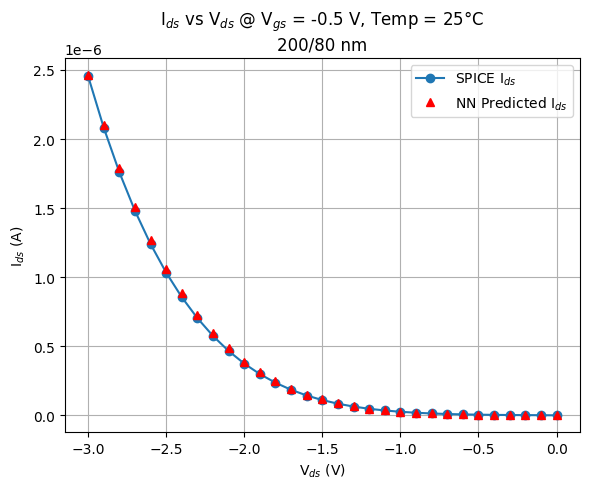

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


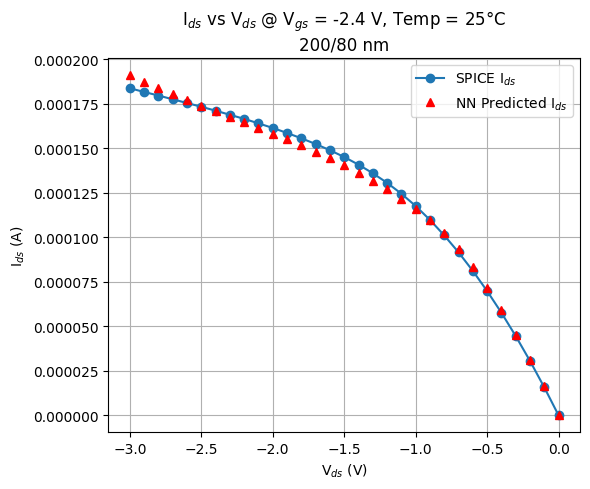

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


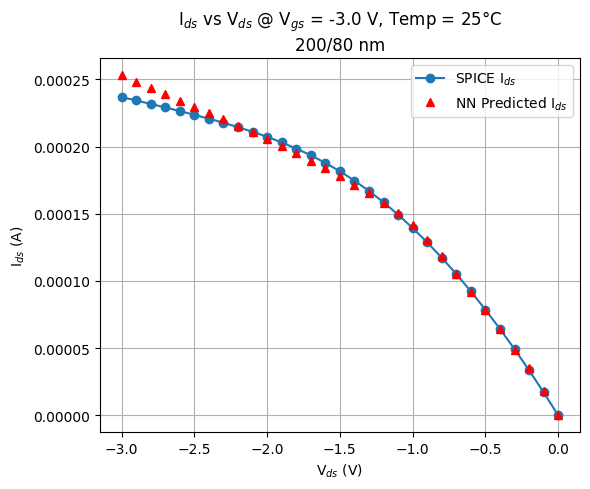

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/80 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


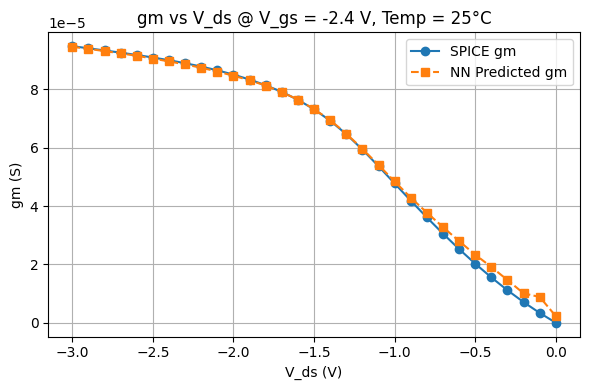

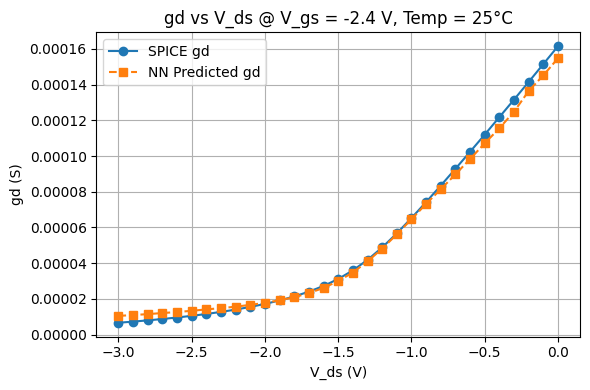

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Set Vgs and temperature for comparison
VGS_TARGET = -2.4
TEMP_TARGET = 25

# Load and filter SPICE data
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
df_filtered = df_spice[mask].sort_values(by="Vds(V)")

if df_filtered.empty:
    print(f"⚠️ No data found for Vgs={VGS_TARGET} V, Temp={TEMP_TARGET}°C")
else:
    # Prepare input
    signature = device_signatures[2]  # Device 1
    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_plot_scaled = scaler.transform(X_plot)

    # Predict with model → outputs: [log10(Id), gm_scaled, gd_scaled]
    y_pred = model.predict(X_plot_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gd_pred_scaled = y_pred[:, 2]

    # Invert standard scaling
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()

    # True gm and gd
    gm_spice = df_filtered["gm"].values
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    # Plot gm
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gm_spice, "o-", label="SPICE gm")
    plt.plot(vds_vals, gm_pred, "s--", label="NN Predicted gm")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gm (S)")
    plt.title(f"gm vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot gd
    plt.figure(figsize=(6, 4))
    plt.plot(vds_vals, gd_spice, "o-", label="SPICE gd")
    plt.plot(vds_vals, gd_pred, "s--", label="NN Predicted gd")
    plt.xlabel("V_ds (V)")
    plt.ylabel("gd (S)")
    plt.title(f"gd vs V_ds @ V_gs = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


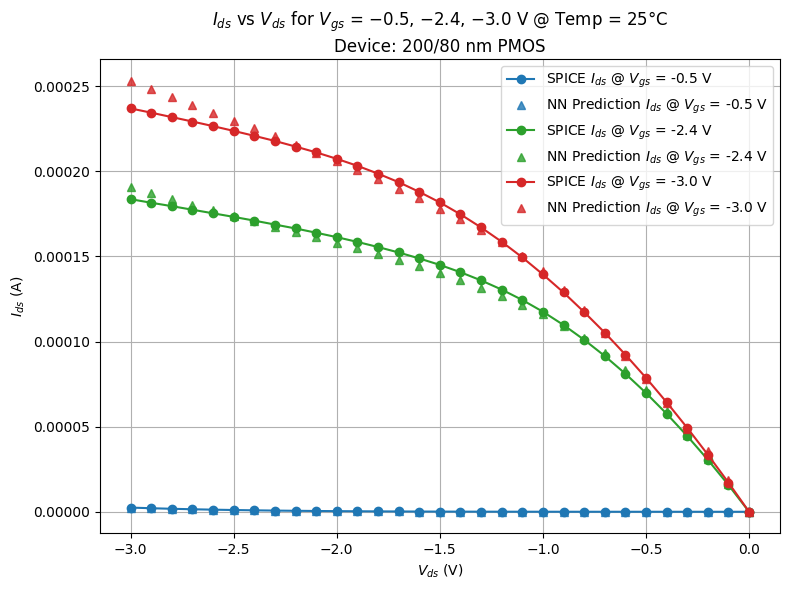

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[2]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/80 nm PMOS")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


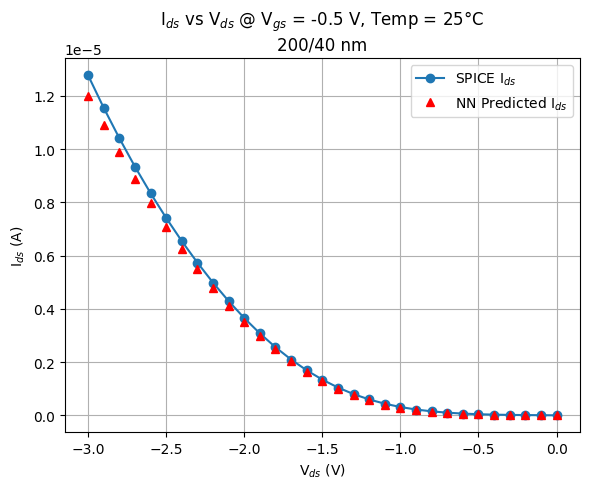

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


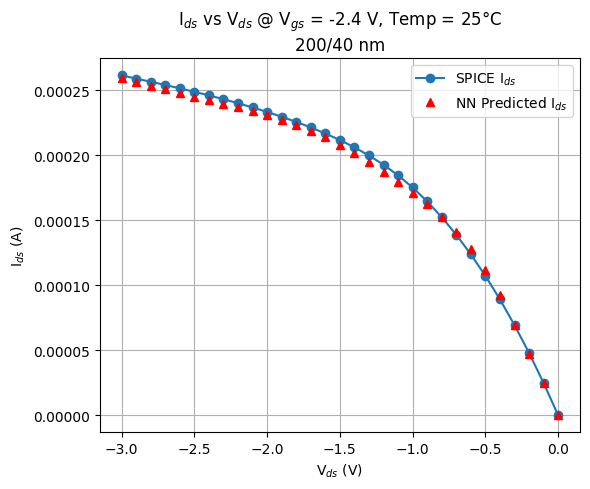

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


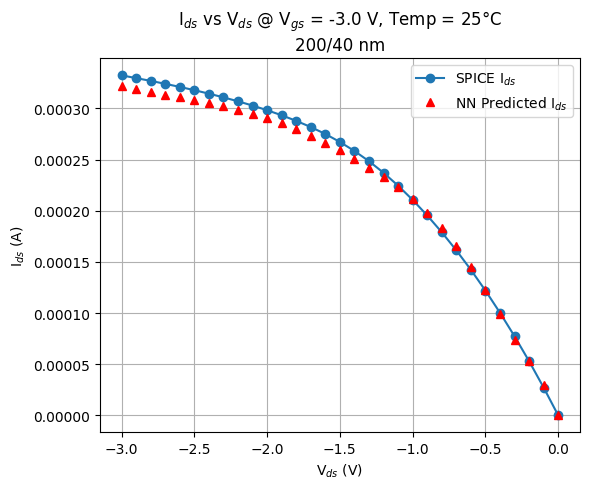

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n200/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


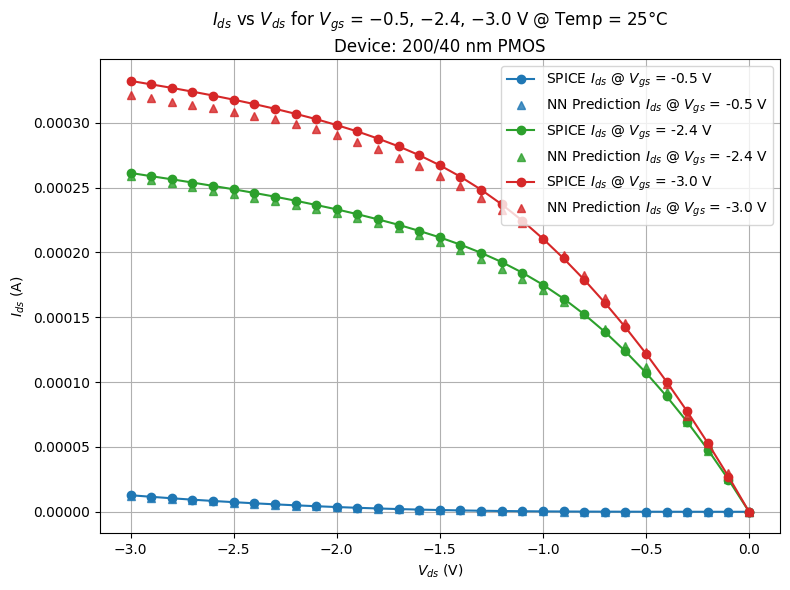

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 200/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


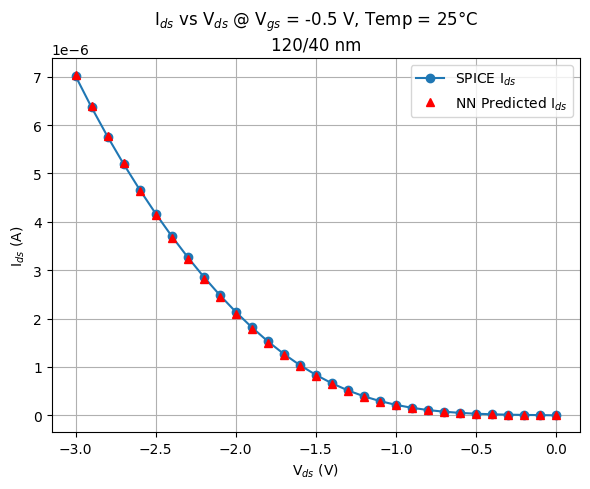

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


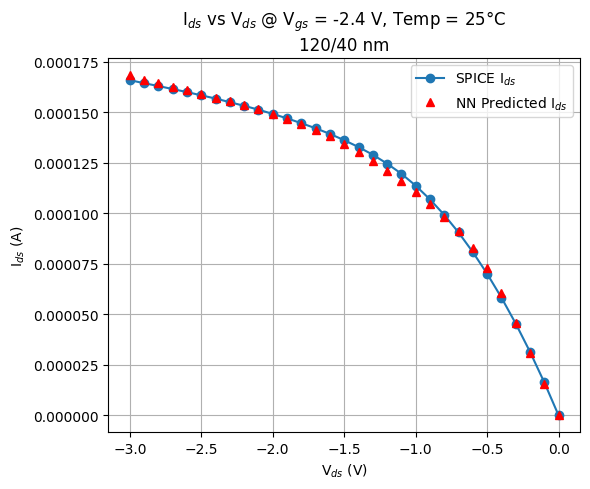

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


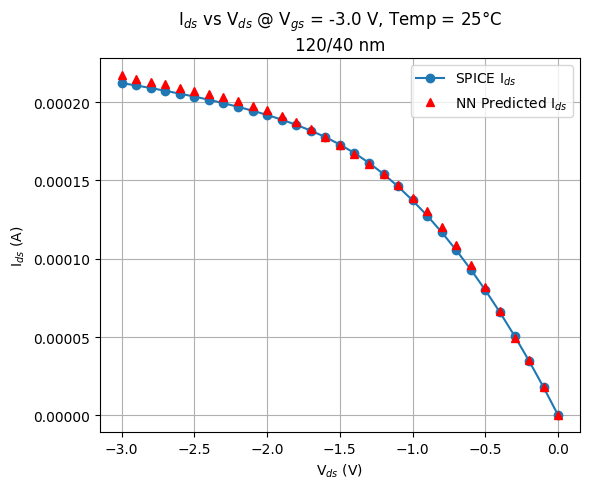

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n120/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


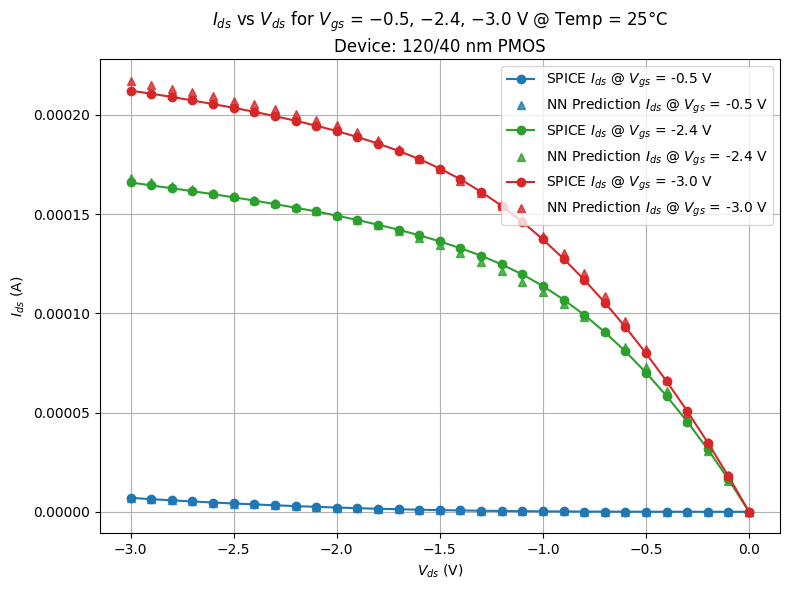

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 120/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


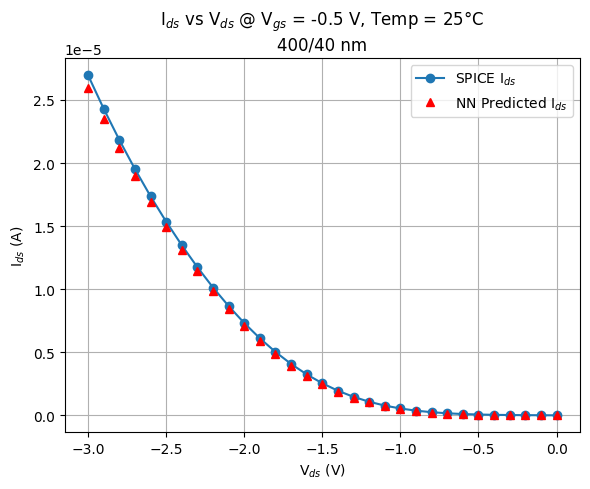

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


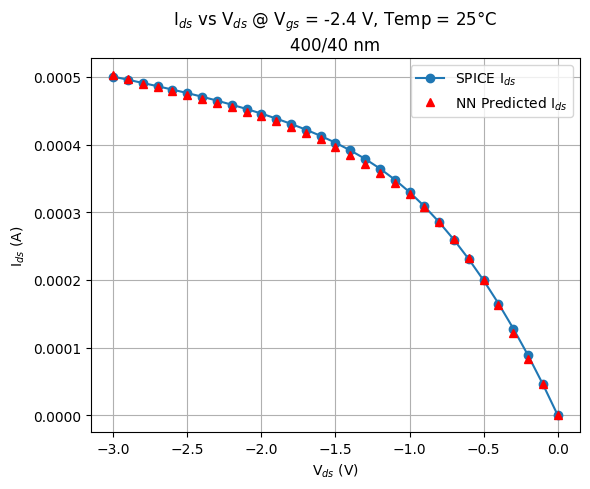

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


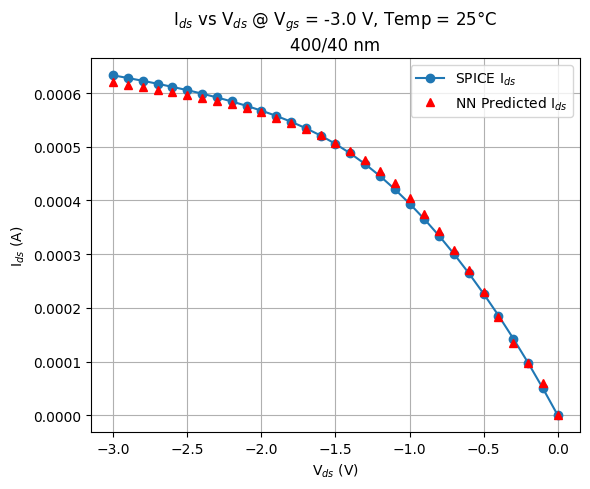

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n400/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


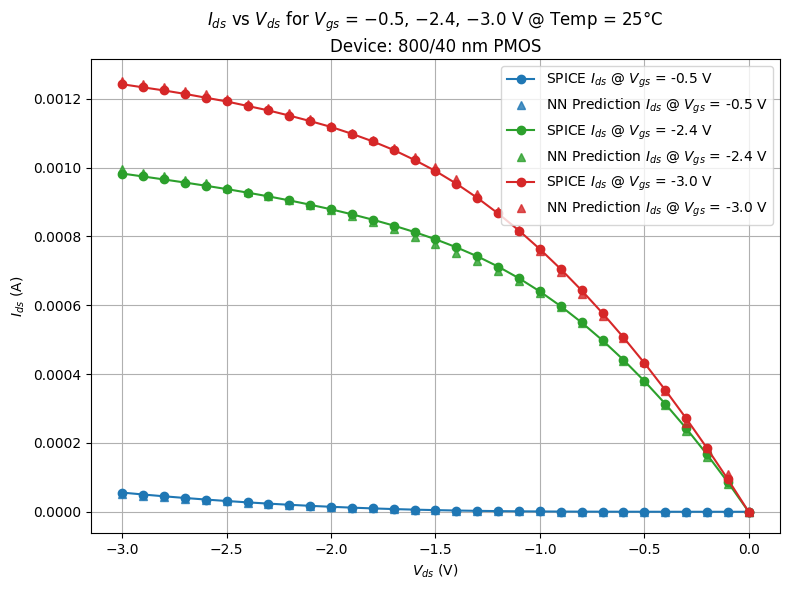

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title("$I_{ds}$ vs $V_{ds}$ for $V_{gs}$ = −0.5, −2.4, −3.0 V @ Temp = 25°C\nDevice: 800/40 nm PMOS")
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


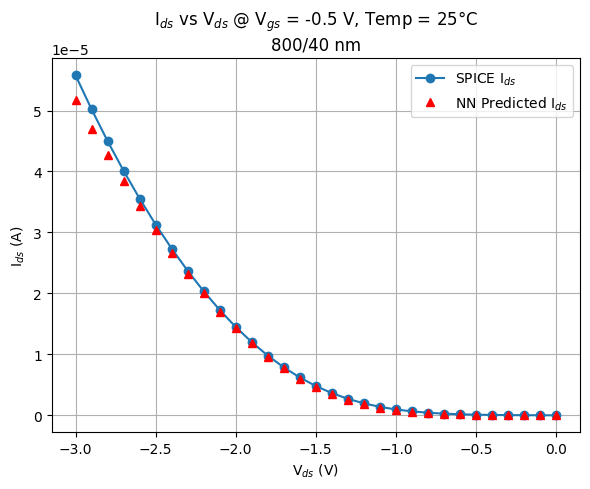

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


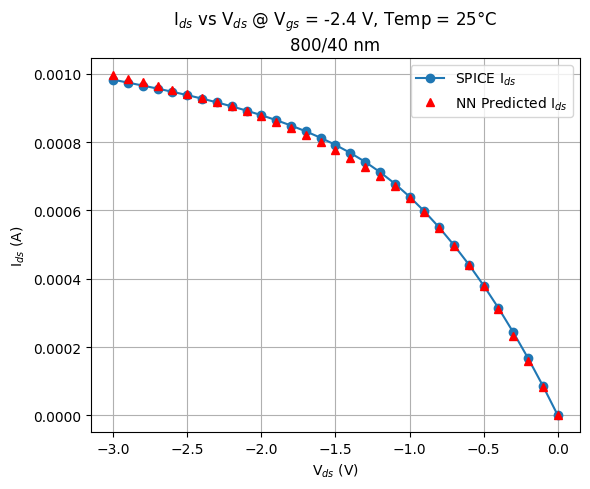

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


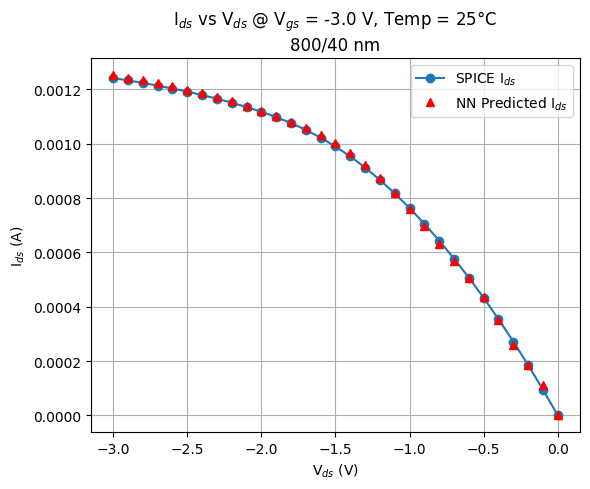

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for Device 1 (nfet_120_40)
df_spice = pd.read_csv("/content/pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for Device 1
TEMP_TARGET = 25
VGS_TARGETS = [-0.5, -2.4, -3.0]

for VGS_TARGET in VGS_TARGETS:
    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)

    # Predict [log_Id, gm_scaled, gd_scaled]
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Get SPICE values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot I_ds vs V_ds
    plt.figure(figsize=(6, 5))
    plt.plot(Vds_vals, Id_spice, "o-", label="SPICE I$_{ds}$")
    # plt.plot(Vds_vals, Id_pred, "s--", label="NN Predicted I$_{ds}$")
    plt.plot(Vds_vals, Id_pred, "^", color='red', label="NN Predicted I$_{ds}$")  # '^' = triangle up


    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ V$_{{gs}}$ = {VGS_TARGET} V, Temp = {TEMP_TARGET}°C\n800/40 nm")

    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


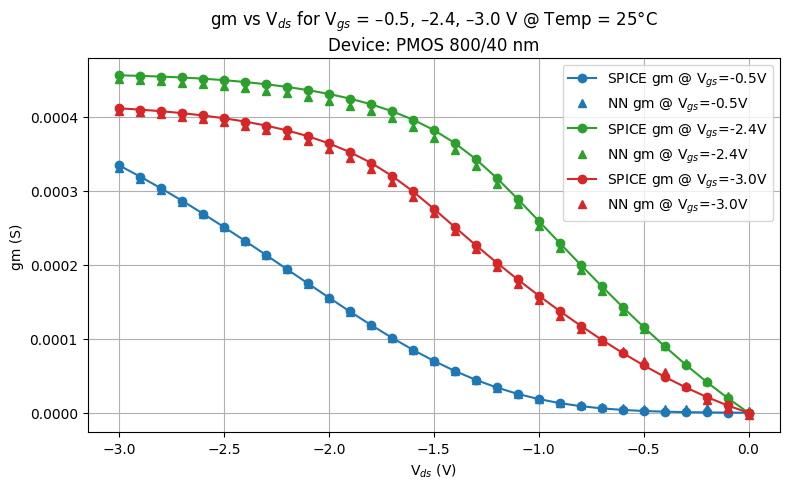

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4  # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No data for Vgs = {VGS_TARGET} V")
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gm_pred_scaled = y_pred[:, 1]
    gm_pred = scaler_gm.inverse_transform(gm_pred_scaled.reshape(-1, 1)).flatten()
    gm_spice = df_filtered["gm"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gm_spice, "o-", color=color, label=f"SPICE gm @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gm_pred, "^", color=color, linestyle='None', label=f"NN gm @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gm (S)")
plt.title("gm vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Figure size 800x500 with 0 Axes>

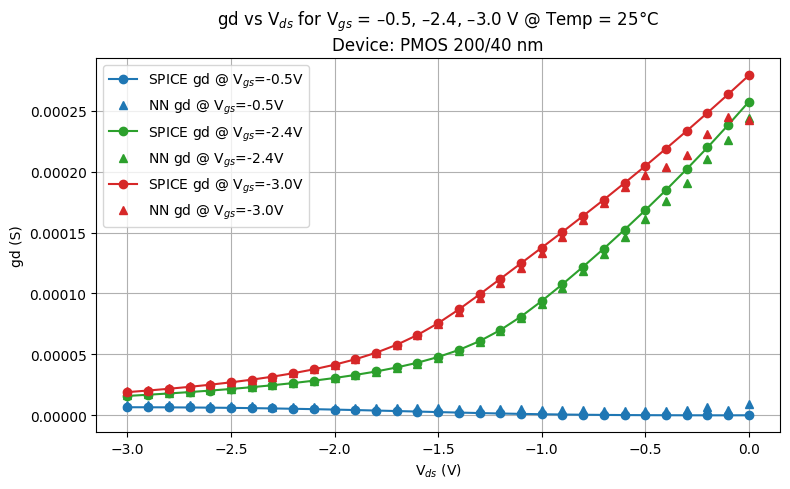

In [71]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 1 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 200/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


<Figure size 800x500 with 0 Axes>

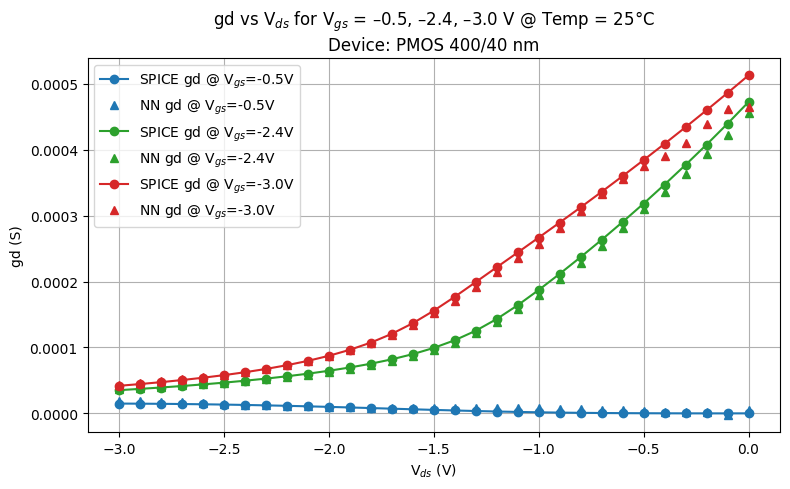

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 3 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 400/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


<Figure size 800x500 with 0 Axes>

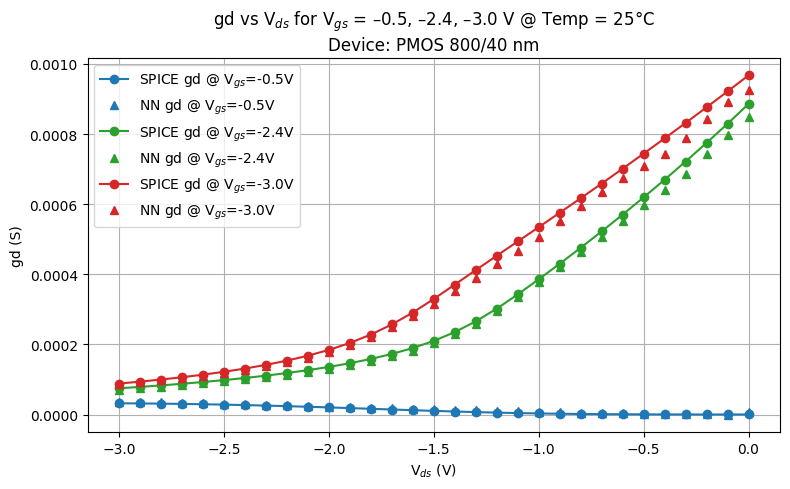

In [73]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

TEMP_TARGET = 25
DEVICE_INDEX = 4 # pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

plt.figure(figsize=(8, 5))  # GM plot



plt.figure(figsize=(8, 5))  # GD plot

for VGS_TARGET in VGS_TARGETS:
    color = COLOR_MAP[VGS_TARGET]
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        continue

    X_plot = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled = scaler.transform(X_plot)
    y_pred = model.predict(X_scaled)
    gd_pred_scaled = y_pred[:, 2]
    gd_pred = scaler_gd.inverse_transform(gd_pred_scaled.reshape(-1, 1)).flatten()
    gd_spice = df_filtered["gds"].values
    vds_vals = df_filtered["Vds(V)"].values

    plt.plot(vds_vals, gd_spice, "o-", color=color, label=f"SPICE gd @ V$_{{gs}}$={VGS_TARGET}V")
    plt.plot(vds_vals, gd_pred, "^", color=color, linestyle='None', label=f"NN gd @ V$_{{gs}}$={VGS_TARGET}V")

plt.xlabel("V$_{ds}$ (V)")
plt.ylabel("gd (S)")
plt.title("gd vs V$_{ds}$ for V$_{gs}$ = –0.5, –2.4, –3.0 V @ Temp = 25°C\nDevice: PMOS 800/40 nm")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


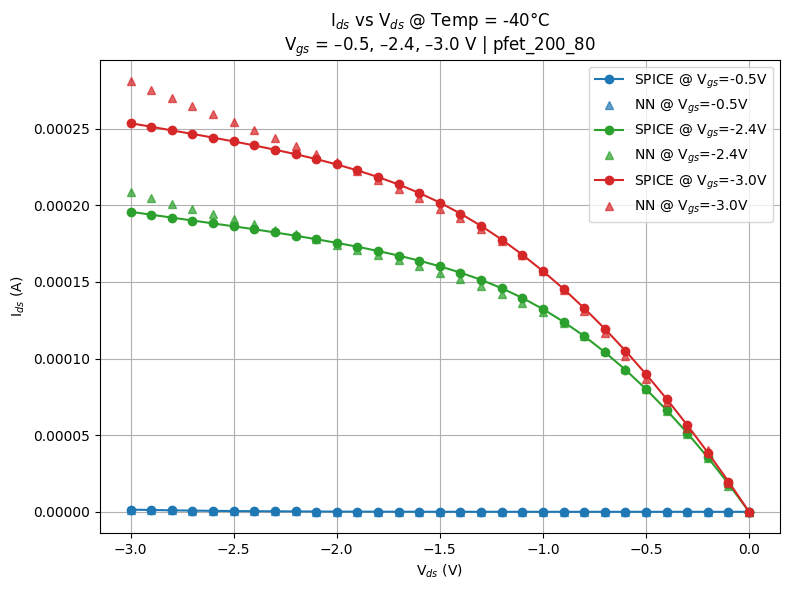

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


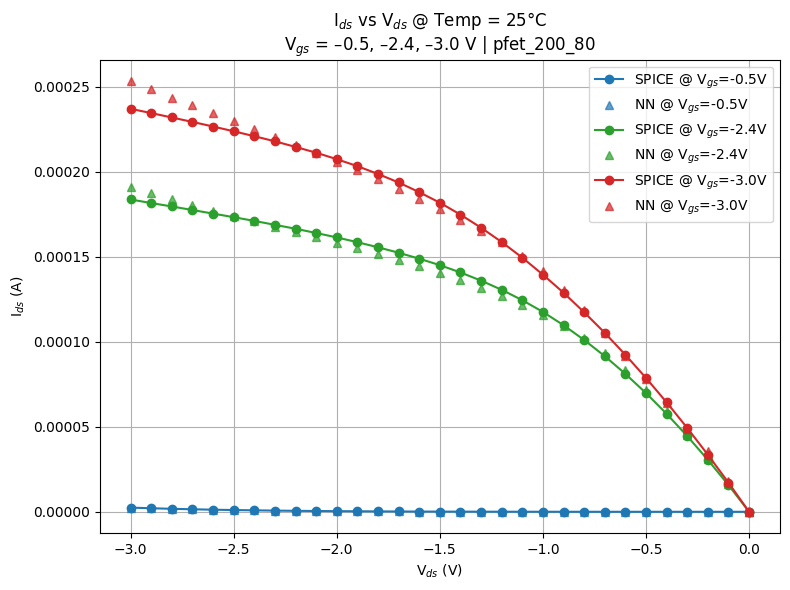

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


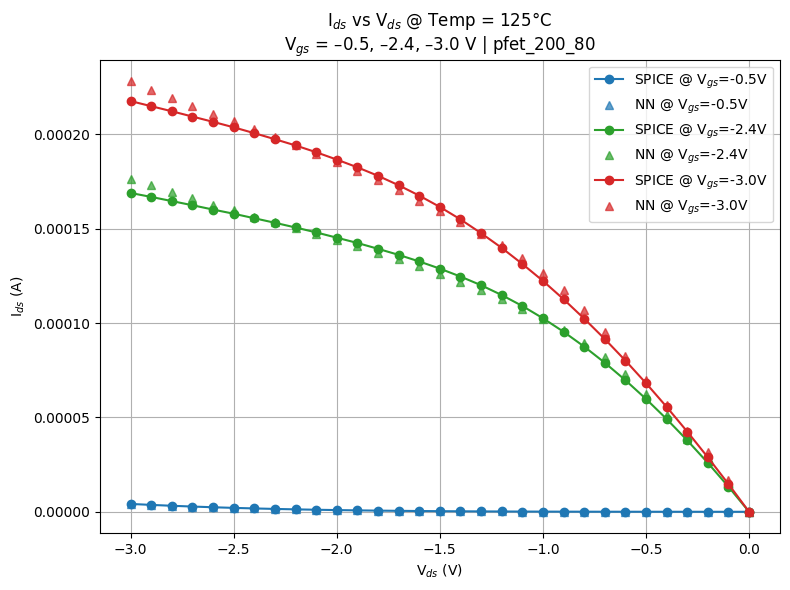

In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 2  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_80.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_80")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


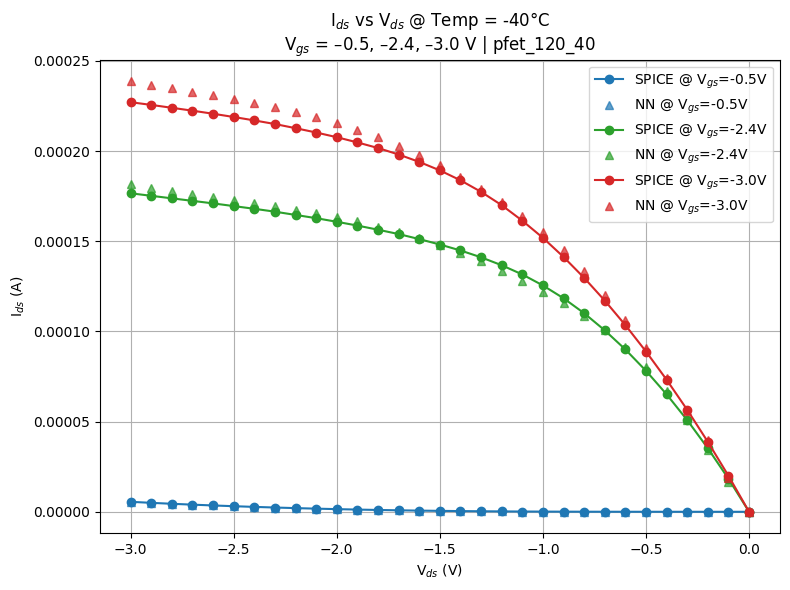

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


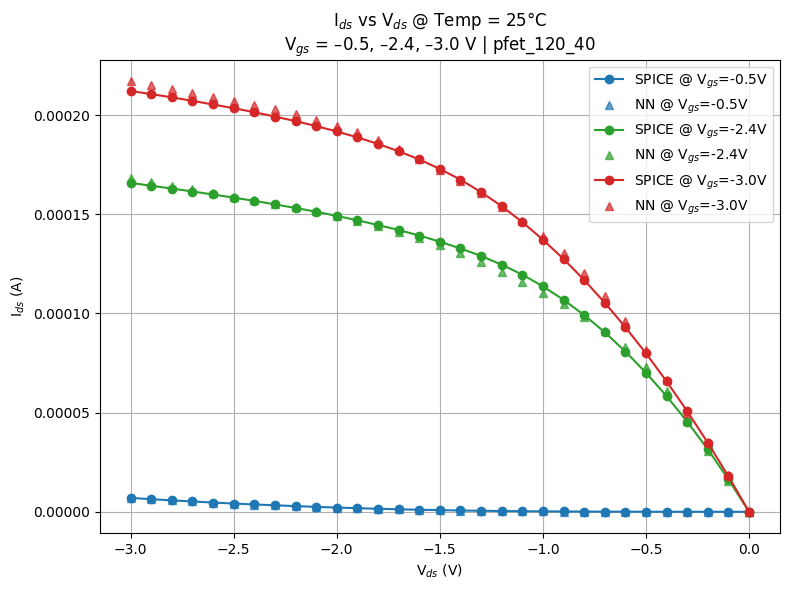

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


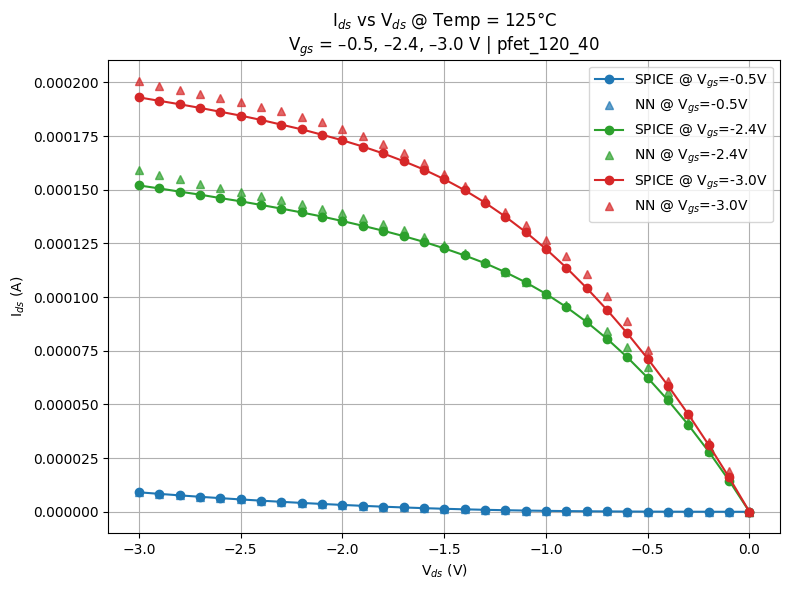

In [75]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 0  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_120_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_120_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


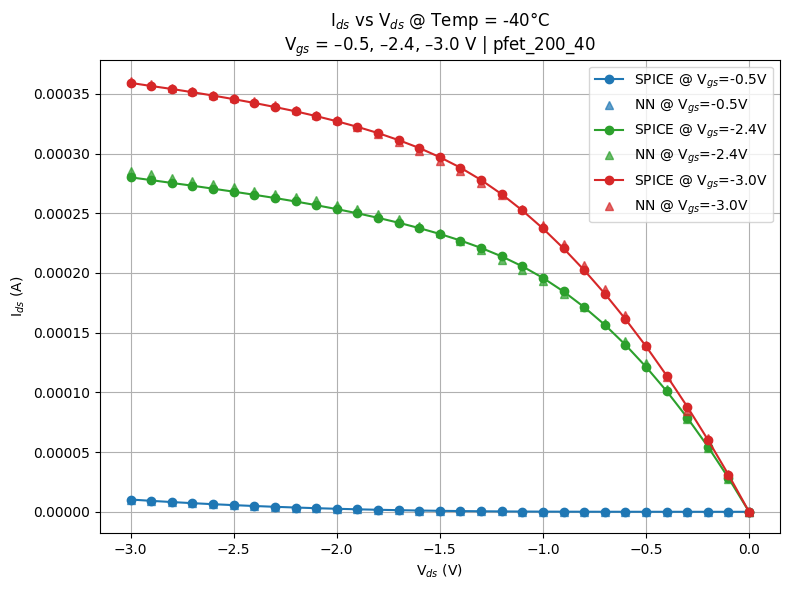

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


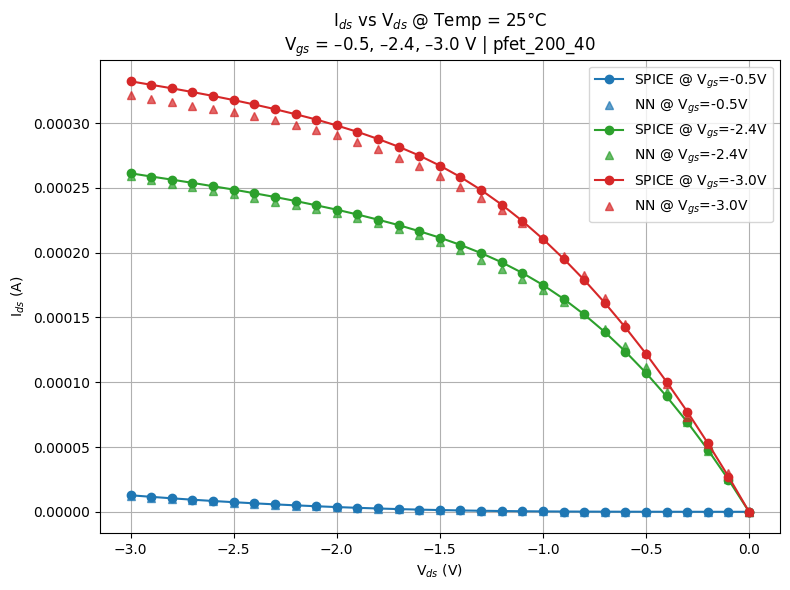

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


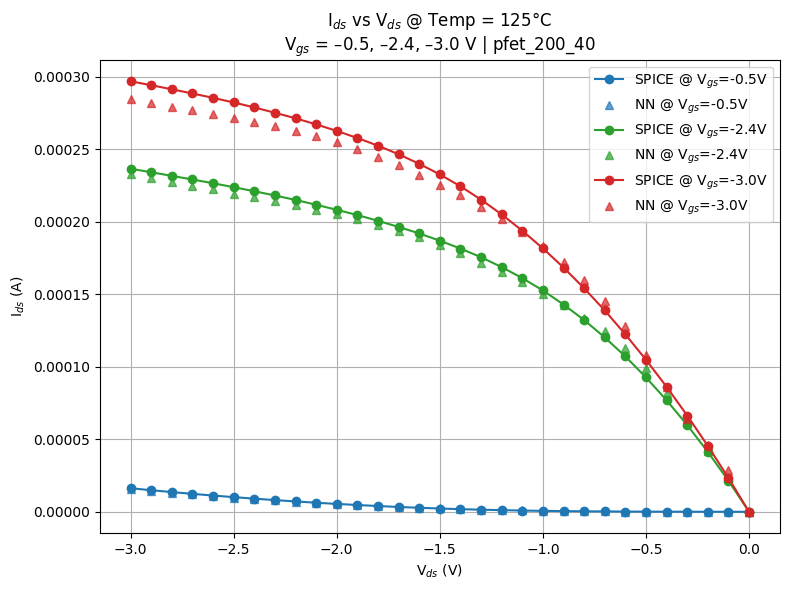

In [76]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 1  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_200_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_200_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


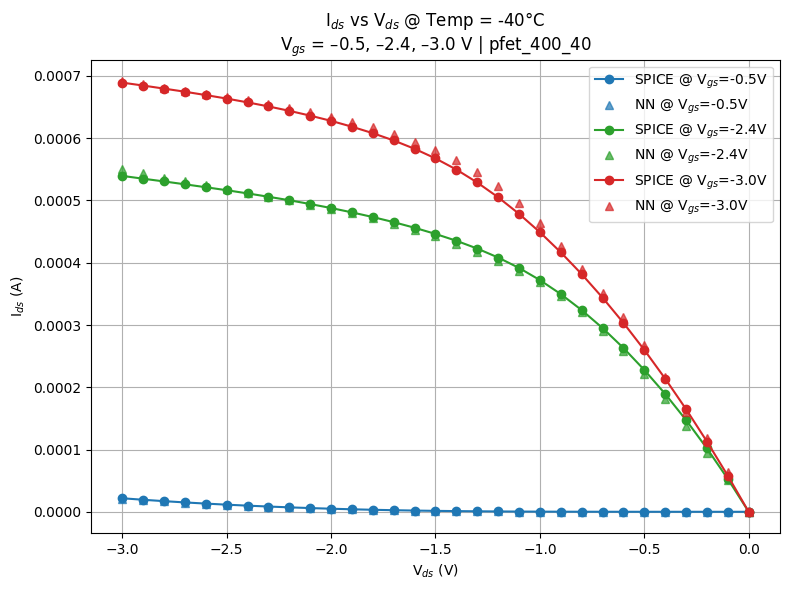

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


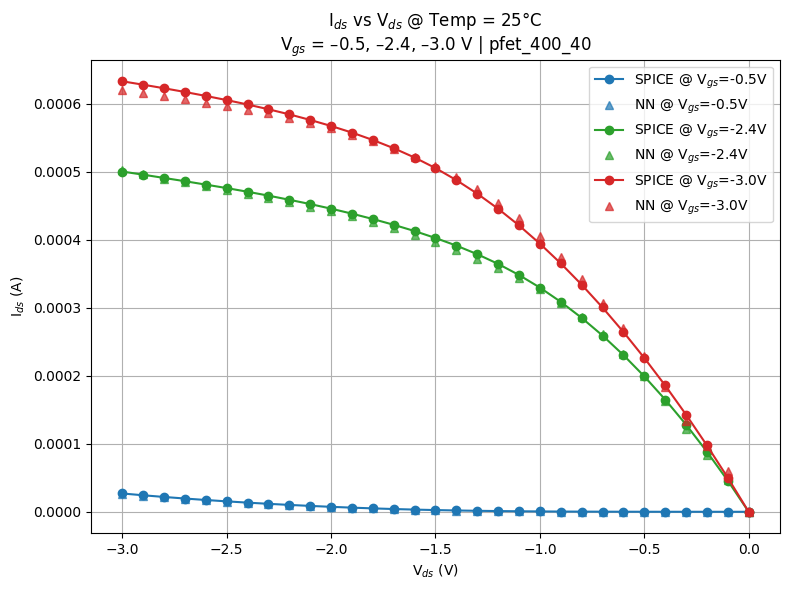

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


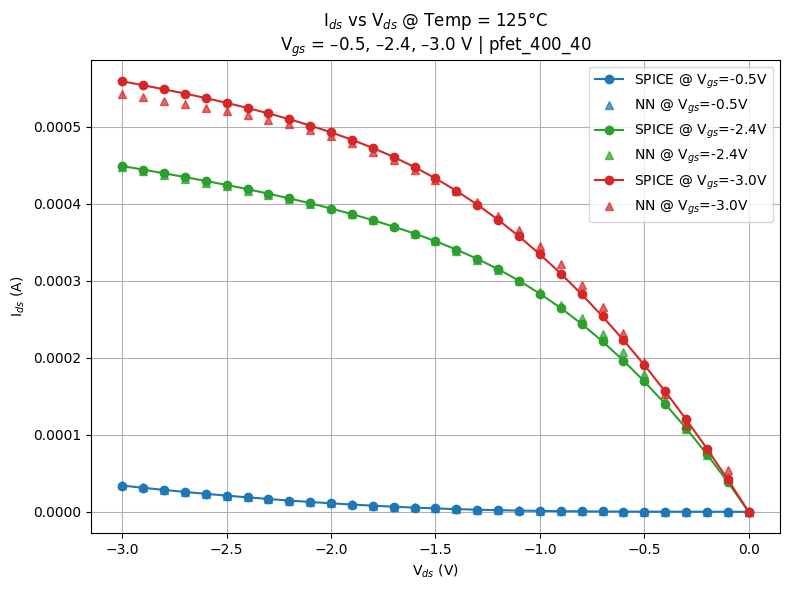

In [77]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 3  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_400_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_400_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


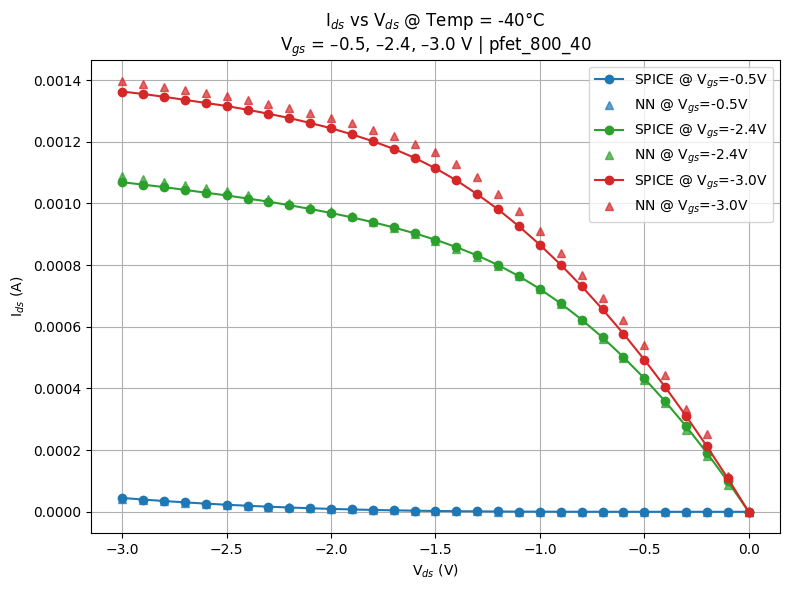

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


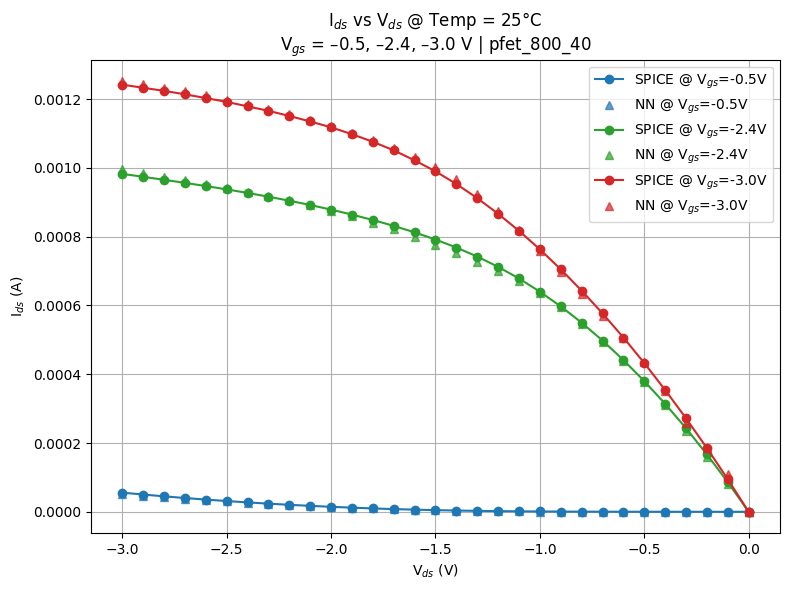

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


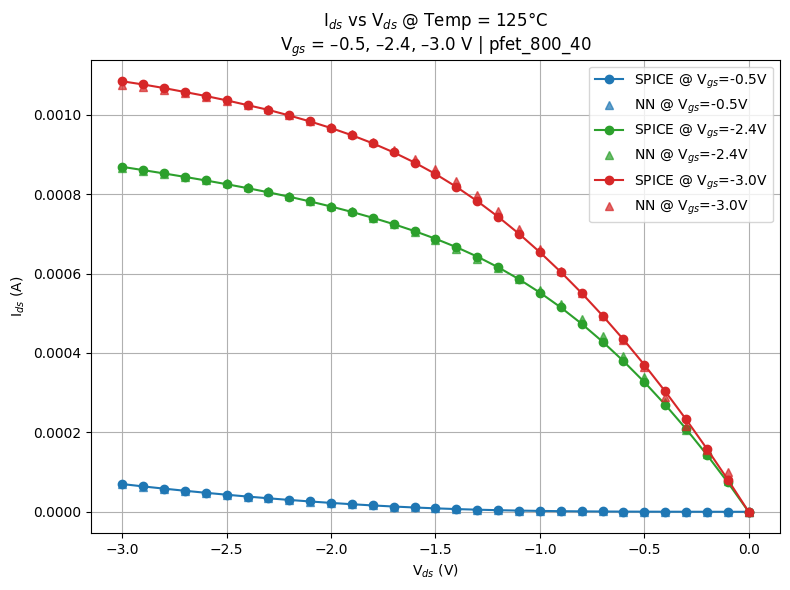

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Configuration
DEVICE_INDEX = 4  # for pfet_200_80.csv
VGS_TARGETS = [-0.5, -2.4, -3.0]
TEMP_TARGETS = [-40, 25, 125]
COLOR_MAP = {-0.5: '#1f77b4', -2.4: '#2ca02c', -3.0: '#d62728'}

# Load data
df_spice = pd.read_csv("pfet_800_40.csv").sort_values(by=["Temp", "Vgs(V)", "Vds(V)"])
signature = device_signatures[DEVICE_INDEX]

# Loop over temperatures
for TEMP in TEMP_TARGETS:
    plt.figure(figsize=(8, 6))
    for VGS_TARGET in VGS_TARGETS:
        color = COLOR_MAP[VGS_TARGET]
        mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP)
        df_filtered = df_spice[mask].sort_values(by="Vds(V)")

        if df_filtered.empty:
            print(f"⚠️ No data for Vgs = {VGS_TARGET} V, Temp = {TEMP}°C")
            continue

        # NN prediction
        X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
        X_scaled = scaler.transform(X_input)
        y_pred = model.predict(X_scaled)
        log_Id_pred = y_pred[:, 0]
        Id_pred = 10 ** log_Id_pred

        # SPICE
        Id_spice = df_filtered["Id(A)"].values
        Vds_vals = df_filtered["Vds(V)"].values

        # Plot both
        plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE @ V$_{{gs}}$={VGS_TARGET}V")
        plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle='None', alpha=0.7, label=f"NN @ V$_{{gs}}$={VGS_TARGET}V")

    plt.xlabel("V$_{ds}$ (V)")
    plt.ylabel("I$_{ds}$ (A)")
    plt.title(f"I$_{{ds}}$ vs V$_{{ds}}$ @ Temp = {TEMP}°C\nV$_{{gs}}$ = –0.5, –2.4, –3.0 V | pfet_800_40")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


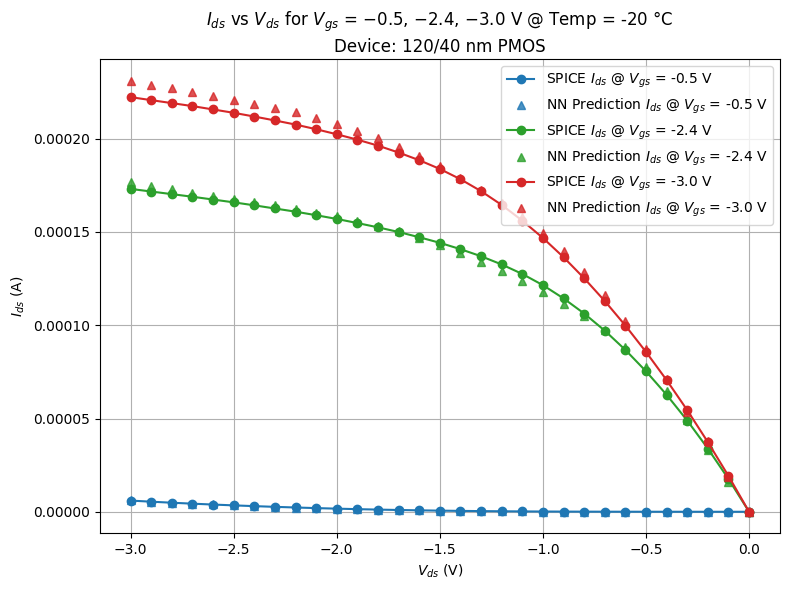

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[0]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


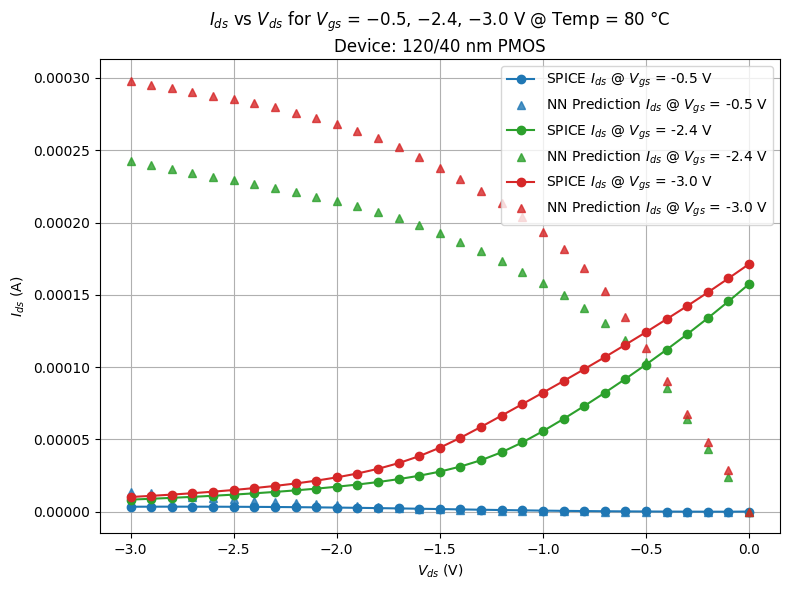

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_120_40__-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 120/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


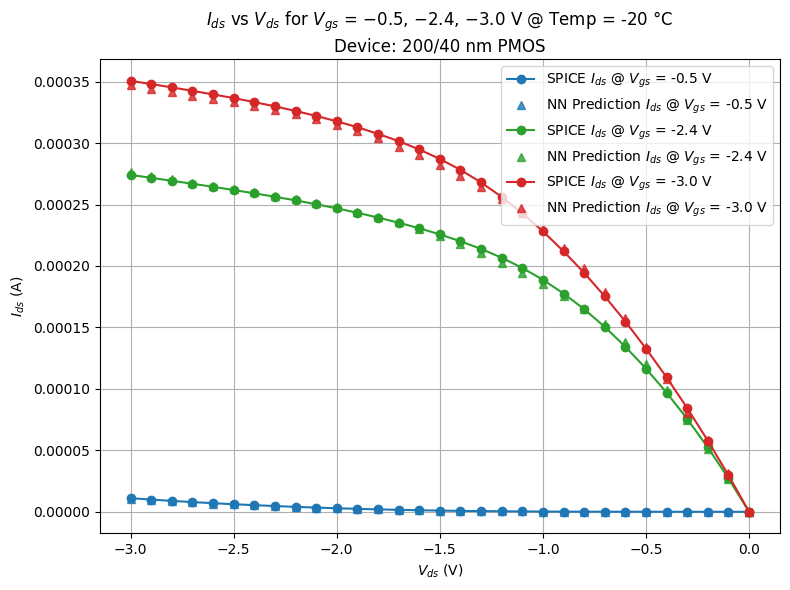

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


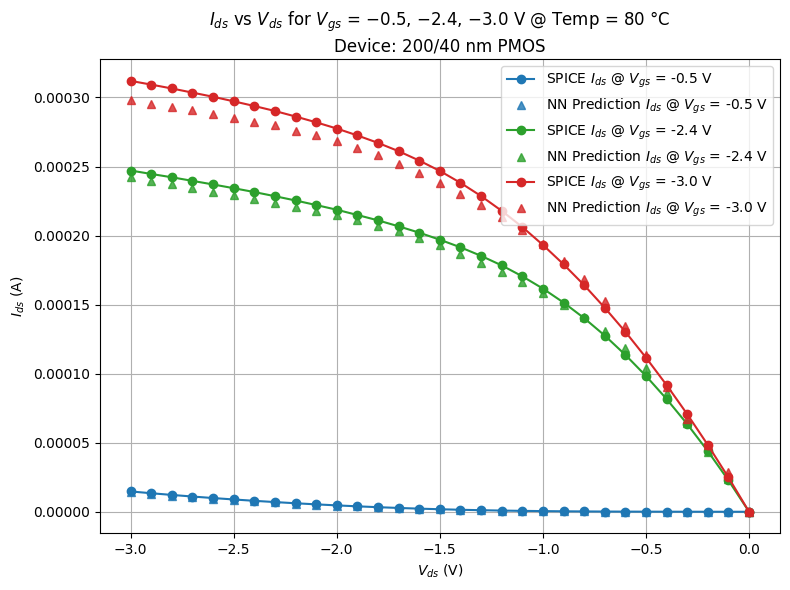

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_200_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[1]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 200/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


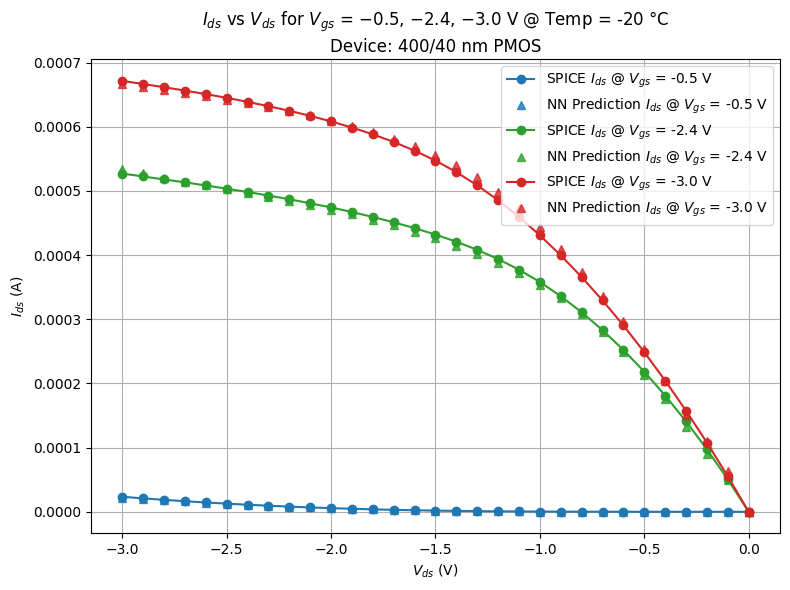

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


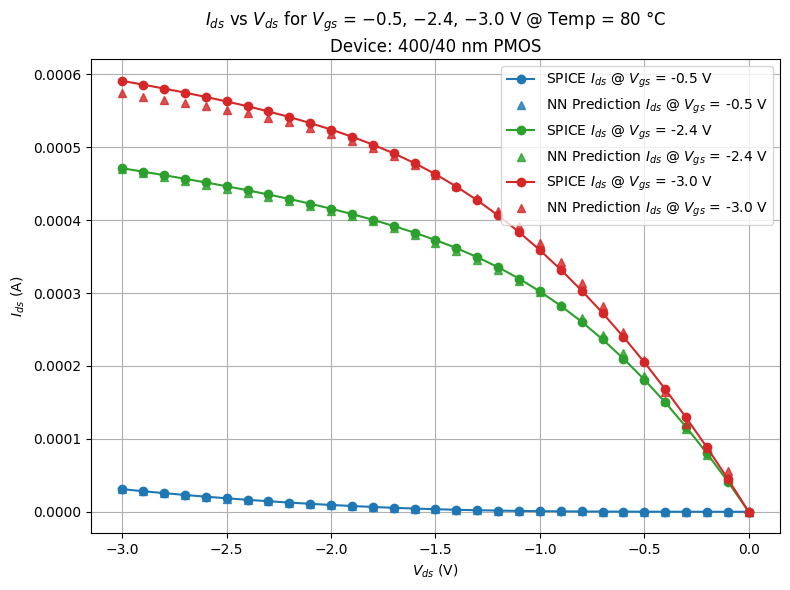

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 400/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


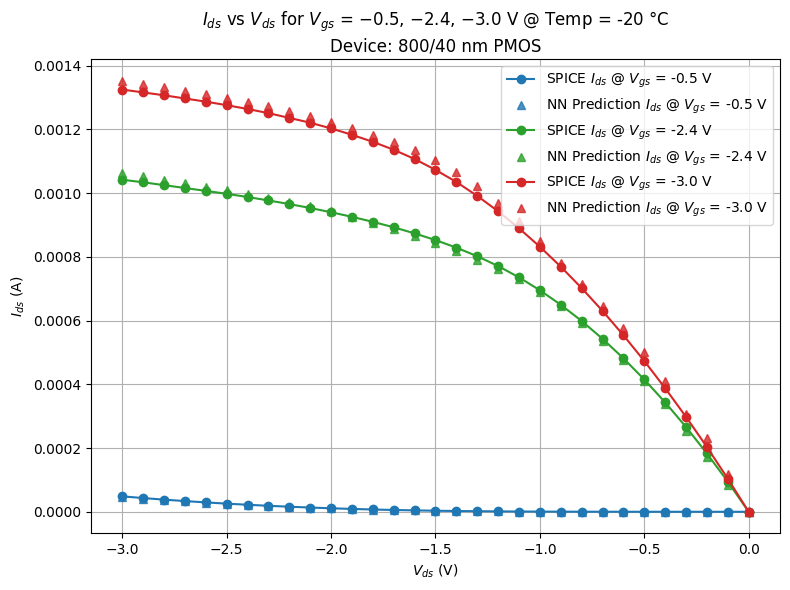

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_800_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[4]  # PCA vector for pfet_120_40
TEMP_TARGET = -20
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


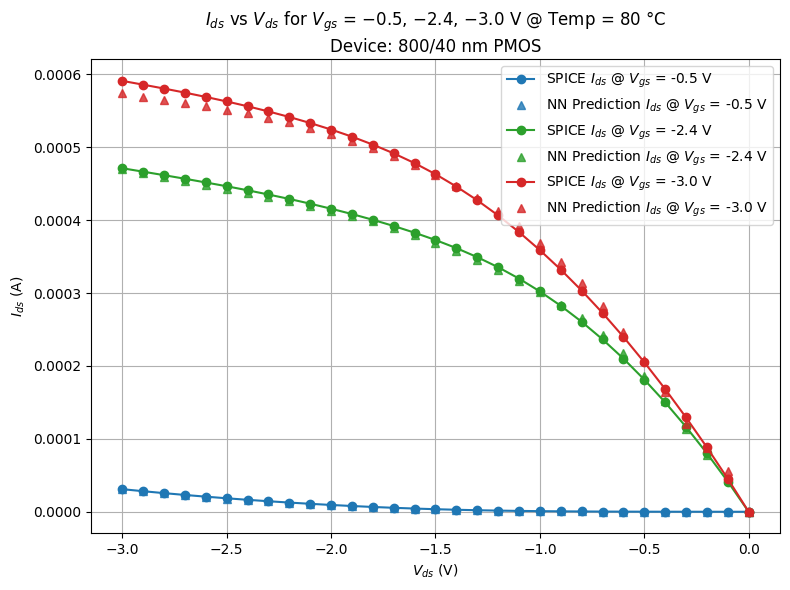

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# File for PMOS Device 1
df_spice = pd.read_csv("/content/pfet_400_40_-20_80.csv").sort_values(by=["Vgs(V)", "Vds(V)"])
signature = device_signatures[3]  # PCA vector for pfet_120_40
TEMP_TARGET = 80
VGS_TARGETS = [-0.5, -2.4, -3.0]

# Color map for each Vgs
color_map = {
    -0.5: '#1f77b4',   # blue
    -2.4: '#2ca02c',   # green
    -3.0: '#d62728'    # red
}

# Initialize combined plot
plt.figure(figsize=(8, 6))

for VGS_TARGET in VGS_TARGETS:
    color = color_map[VGS_TARGET]

    # Filter SPICE data
    mask = (df_spice["Vgs(V)"] == VGS_TARGET) & (df_spice["Temp"] == TEMP_TARGET)
    df_filtered = df_spice[mask].sort_values(by="Vds(V)")

    if df_filtered.empty:
        print(f"⚠️ No SPICE data found for Vgs = {VGS_TARGET} V at {TEMP_TARGET}°C")
        continue

    # Prepare model input
    X_input = [[*signature, row["Vgs(V)"], row["Vds(V)"], row["Temp"]] for _, row in df_filtered.iterrows()]
    X_scaled_input = scaler.transform(X_input)
    y_pred = model.predict(X_scaled_input)
    log_Id_pred = y_pred[:, 0]
    Id_pred = 10 ** log_Id_pred

    # Extract values
    Id_spice = df_filtered["Id(A)"].values
    Vds_vals = df_filtered["Vds(V)"].values

    # Plot SPICE and NN with same color, but different markers
    plt.plot(Vds_vals, Id_spice, "o-", color=color, label=f"SPICE $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")
    plt.plot(Vds_vals, Id_pred, "^", color=color, linestyle="None", alpha=0.8, label=f"NN Prediction $I_{{ds}}$ @ $V_{{gs}}$ = {VGS_TARGET} V")

# Final labels and styling
plt.xlabel("$V_{ds}$ (V)")
plt.ylabel("$I_{ds}$ (A)")
plt.title(f"$I_{{ds}}$ vs $V_{{ds}}$ for $V_{{gs}}$ = −0.5, −2.4, −3.0 V @ Temp = {TEMP_TARGET} °C\nDevice: 800/40 nm PMOS")
plt.legend(loc="upper right")
plt.grid(True)
plt.tight_layout()
plt.show()
